In [136]:
from datetime import tzinfo
import datetime as dt

from debugpy.common.log import warning
from kiwisolver import strength
from scipy.io import loadmat
import pandas as pd
import numpy as np

file_name = "../../../data/visible_events.mat"
data = loadmat(file_name)
col = ['distance', 'depth', 'phase', 'travel_time', 'year', 'month', 'day', 'h', 'm', 's', 'mag', 'e1', 'e2', 'e3', 'associated_file' ]
df = []
for line in data['events_list'].flatten():
    # print(line.split())
    df.append(line.split())
df = np.array(df)
df = pd.DataFrame(df,columns=col)
df.astype = {'distance'       :   'float64',
             'depth'          :   'float64',
             'phase'          :   'str',
             'travel_time'    :   'float64',
             'year'           :   'float64',
             'month'          :   'float64',
             'day'            :   'float64',
             'h'              :   'float64',
             'm'            :   'float64',
             's'              :   'float64',
             'mag'            :   'float64',
             'e1'             :   'float64',
             'e2'             :   'float64',
             'e3'             :   'float64',
             'associated_file':   'str' }
df['datetime'] = pd.to_datetime(df[['year','month','day','h','m','s']],utc=True)
df = df[['datetime','distance','depth','phase','travel_time','mag','associated_file']]
df["phase"].unique()

array(['PKIKP', 'PKP', 'P', 'PKiKP'], dtype=object)

In [137]:
import datetime
from haversine import haversine, Unit
from obspy.taup import TauPyModel
######################################
PATH = 'C:/Users/Romain/PycharmProjects/NEIC_ISC_join/data'
NAME_NEIC = '/NEIC_2018_M6.csv'

######################################
######################################
neic = pd.read_csv(PATH + NAME_NEIC, parse_dates=['time'], date_format='ISO8601')

#print(neic.columns.values)
#['time' 'latitude' 'longitude' 'depth' 'mag' 'magType' 'nst' 'gap' 'dmin'
# 'rms' 'net' 'id' 'updated' 'place' 'type' 'horizontalError' 'depthError'
# 'magError' 'magNst' 'status' 'locationSource' 'magSource']
# ELAN coords
st_lat, st_lon = -56.4602,	62.976
coords = (-18.1125,-178.153)
Elan = (st_lat, st_lon)
dist = haversine(coords, Elan) / 111
depth = 600
model = TauPyModel(model="ak135")
arrivals = model.get_travel_times(source_depth_in_km=depth,
                              distance_in_degree=dist, phase_list=["P"])
print(dist)
print(arrivals[0])

h = datetime.datetime(2018, 8, 19, 00, 19, 40, 67)
h = h + datetime.timedelta(seconds=arrivals[0].time)
h

89.83874757777151
P phase arrival at 715.809 seconds


datetime.datetime(2018, 8, 19, 0, 31, 35, 809409)

In [138]:
from src.utils.data_reading.sound_data.sound_file import DatFile
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager

In [139]:
from datetime import timedelta
from utils.physics.signal.make_spectrogram import make_spectrogram
import matplotlib.pyplot as plt
i =10
path = "F:/OHASISBIO/2018/ELAN"  # put a DAT directory here
start = df['datetime'].iloc[i]+timedelta(seconds=np.float64(df['travel_time'].iloc[i]))-timedelta(minutes=2)
start = start.replace(tzinfo=None)
end = df['datetime'].iloc[i]+timedelta(seconds=np.float64(df['travel_time'].iloc[i]))+timedelta(minutes=2)
end =end.replace(tzinfo=None)

manager = DatFilesManager(path,kwargs="raw")
data = manager.get_segment(start,end)
print(manager.find_file_name(start))
f, t, spectro = make_spectrogram(data, manager.sampling_f, t_res=0.05, f_res=1, return_bins=True)
plt.figure()
plt.imshow(spectro, aspect="auto", cmap="jet", extent=(t[0], t[-1], f[0], f[-1]))
plt.axvline(x=30)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar()

252


In [140]:
f = manager.sampling_f
n = len(data)
%matplotlib qt
times = np.arange(n)/f
print(len(times))
print(n)
plt.figure()
plt.plot(times, data)
plt.axvline(0.5*n/f, color='r')

57597
57597


In [141]:
import numpy as np
import scipy.signal as signal
import pywt
import matplotlib.pyplot as plt
%matplotlib

# Constants
fs = 240  # Sampling frequency (Hz)
lowcut = 0.6 # Lower cutoff frequency for band-pass filter
highcut = 10  # Upper cutoff frequency for band-pass filter

# Load Your Data (Replace with your own data)
# Example: Simulated seismic signal with noise
t = times  # 60 seconds of data
data = data

# 1. Band-Pass Filter (Butterworth)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)
    # a = signal.butter(order, [low, high], btype='band',output='sos')
    # return signal.sosfiltfilt( a, data)

filtered_data = bandpass_filter(data, lowcut, highcut, fs)

def wavelet_denoise(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Noise estimation
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs_denoised = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the signal
    denoised = pywt.waverec(coeffs_denoised, wavelet)

    # Ensure the output length matches the input
    if len(denoised) > len(data):
        denoised = denoised[:len(data)]
    elif len(denoised) < len(data):
        denoised = np.pad(denoised, (0, len(data) - len(denoised)), mode='edge')

    return denoised

denoised_data = wavelet_denoise(filtered_data)

# 3. STA/LTA Detection
def sta_lta(data, fs, sta_window=1, lta_window=10, threshold=3):
    sta_samples = int(sta_window * fs)
    lta_samples = int(lta_window * fs)

    sta = np.convolve(data**2, np.ones(sta_samples)/sta_samples, mode='same')
    lta = np.convolve(data**2, np.ones(lta_samples)/lta_samples, mode='same')

    lta[lta == 0] = np.finfo(float).eps  # Avoid division by zero
    ratio = sta / lta

    event_indices = np.where(ratio > threshold)[0]
    return event_indices, ratio

event_indices, sta_lta_ratio = sta_lta(denoised_data, fs)

# 4. Plot Results
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, data, label="Raw Data", alpha=0.6)
plt.title("Raw Underwater Acoustic Signal")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, filtered_data, label="Filtered & Denoised", color='g')
plt.title("Filtered & Denoised Signal")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, sta_lta_ratio, label="STA/LTA Ratio", color='r')
plt.axhline(y=3, color='k', linestyle="--", label="Threshold")
plt.scatter(t[event_indices], sta_lta_ratio[event_indices], color='black', marker='o', label="Detected P-Wave")
plt.title("STA/LTA P-Wave Detection")
plt.legend()

plt.tight_layout()
plt.show()


Using matplotlib backend: qtagg


In [142]:
import numpy as np
import scipy.signal as signal
import pywt
import matplotlib.pyplot as plt

# Constants
fs = 240  # Sampling frequency (Hz)
# Adapted filter parameters for teleseismic P-waves
lowcut = 0.6   # Lower cutoff frequency (Hz)
highcut = 2.0  # Upper cutoff frequency (Hz)
t = times
data = data
# Assuming 'data' and 't' are already defined
n = len(data)  # Number of samples
p_wave_time = 0.5 * n / fs  # Expected P-wave time
data_norm = data / np.max(np.abs(data))


# 1. Band-Pass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data), b, a

filtered_data, b, a = bandpass_filter(data_norm, lowcut, highcut, fs)

# 2. Wavelet Denoising
def wavelet_denoise(data, wavelet='sym5', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Noise estimation
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs_denoised = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    denoised = pywt.waverec(coeffs_denoised, wavelet)

    if len(denoised) > len(data):
        denoised = denoised[:len(data)]
    elif len(denoised) < len(data):
        denoised = np.pad(denoised, (0, len(data) - len(denoised)), mode='edge')

    return denoised

denoised_data = wavelet_denoise(filtered_data)

# 3. STA/LTA Detection
def sta_lta(data, fs, sta_window=1, lta_window=10, threshold=3):
    sta_samples = int(sta_window * fs)
    lta_samples = int(lta_window * fs)

    sta = np.convolve(data**2, np.ones(sta_samples)/sta_samples, mode='same')
    lta = np.convolve(data**2, np.ones(lta_samples)/lta_samples, mode='same')

    lta[lta == 0] = np.finfo(float).eps  # Avoid division by zero
    ratio = sta / lta

    event_indices = np.where(ratio > threshold)[0]
    return event_indices, ratio

event_indices, sta_lta_ratio = sta_lta(denoised_data, fs)

# 4. Detect P-Wave in STA/LTA
detected_p_wave_time = event_indices[0] / fs if len(event_indices) > 0 else None

# 5. Plot Results
plt.figure(figsize=(12, 8))

# (A) Plot Raw Data
plt.subplot(4, 1, 1)
plt.plot(t, data, label="Raw Data", alpha=0.6)
plt.axvline(p_wave_time, color='r', linestyle="--", label="Expected P-Wave")
plt.title("Raw Underwater Acoustic Signal")
plt.legend()

# (B) Plot Filtered Data
plt.subplot(4, 1, 2)
plt.plot(t, filtered_data, label="Band-Pass Filtered (0.5–15 Hz)", color='g')
plt.axvline(p_wave_time, color='r', linestyle="--", label="Expected P-Wave")
plt.title("Band-Pass Filtered Signal")
plt.legend()

# (C) Plot Denoised Data
plt.subplot(4, 1, 3)
plt.plot(t, denoised_data, label="Wavelet Denoised", color='b')
plt.axvline(p_wave_time, color='r', linestyle="--", label="Expected P-Wave")
if detected_p_wave_time:
    plt.axvline(detected_p_wave_time, color='black', linestyle=":", label="Detected P-Wave")
plt.title("Filtered & Wavelet Denoised Signal")
plt.legend()

# (D) STA/LTA Detection
plt.subplot(4, 1, 4)
plt.plot(t, sta_lta_ratio, label="STA/LTA Ratio", color='r')
plt.axhline(y=3, color='k', linestyle="--", label="Threshold")
plt.axvline(p_wave_time, color='r', linestyle="--", label="Expected P-Wave")
if detected_p_wave_time:
    plt.axvline(detected_p_wave_time, color='black', linestyle=":", label="Detected P-Wave")
plt.title("STA/LTA P-Wave Detection")
plt.legend()

plt.tight_layout()
plt.show()

# 6. Plot Band-Pass Filter Response
w, h = signal.freqz(b, a, worN=1024, fs=fs)
plt.figure(figsize=(8, 4))
plt.plot(w, abs(h), 'b')
plt.title("Band-Pass Filter Frequency Response (0.5–15 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.grid()
plt.show()

# Print Detected P-Wave Time
if detected_p_wave_time:
    print(f"Detected P-wave at {detected_p_wave_time:.2f} seconds (Expected ~{p_wave_time:.2f}s)")
else:
    print(f"No P-wave detected. Expected at {p_wave_time:.2f} seconds.")


Detected P-wave at 15.42 seconds (Expected ~119.99s)


In [143]:
%matplotlib qt
plt.figure(figsize=(12, 8))
plt.plot(t,filtered_data, color='r')
plt.plot(t, denoised_data, label="Wavelet Denoised", color='b')
plt.axvline(p_wave_time, color='r', linestyle="--", label="Expected P-Wave")

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, detrend, spectrogram

# Load data

fs = 240
time = np.arange(len(data)) / fs

# Detrend
data = detrend(data, type='linear')

# Design filters (MATLAB parameters)
nyquist = fs / 2
b_high, a_high = butter(4, 0.06 , btype='high', fs=240)  # High-pass
b_low, a_low = butter(6, 2.1 , btype='low', fs=240)     # Low-pass

# 3. Apply filters with MATLAB-like padding
filtered_high = filtfilt(b_high, a_high, data, padtype='constant', padlen=30)
filtered_data = filtfilt(b_low, a_low, filtered_high, padtype='constant', padlen=30)

# 4. Plot results
plt.plot(time, filtered_data, 'b', linewidth=0.75)
plt.title("Python Output (MATLAB-like Padding)")
plt.show()

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# Sampling frequency and time vector
Fs = 250                # 100 Hz sampling frequency
N = n                 # Number of samples (adjust as needed)
time =times

# Simulated seismic signal:
# For example, a low-frequency sine with some noise and a higher-frequency component.
signal =data
# Define filter coefficients exactly as in MATLAB for Fs = 100 Hz:
#
# Filter 1: Hippocampe OBS (cut ~1 Hz)
# MATLAB: a = [1, -94/100, 0], b = [1, -1, 0]
b1 = np.array([1, -1, 0])
a1 = np.array([1, -94/240, 0])

# Filter 2: Mermaid electronic card (cut ~0.1 Hz; weak filter)
# MATLAB: a = [1, -9965/10000, 0], b = [1, -1, 0]
b2 = np.array([1, -1, 0])
a2 = np.array([1, -9965/240, 0])

# Filter 3: High-pass filter cutting approximately at 0.3 Hz
# MATLAB: a = [1, -99/100, 0], b = [1, -1, 0]
b3 = np.array([1, -1, 0])
a3 = np.array([1, -99/240, 0])

# Apply zero-phase filtering (filtfilt applies forward and backward filtering)
filtered_signal1 = filtfilt(b1, a1, signal)
filtered_signal2 = filtfilt(b2, a2, signal)
filtered_signal3 = filtfilt(b3, a3, signal)

# Plotting the original and filtered signals
plt.figure(figsize=(12, 8))
plt.plot(time, signal, label='Original Signal', color='gray', alpha=0.5)
plt.plot(time, filtered_signal1, label='Hippocampe OBS (cut ~1 Hz)', linewidth=2)
plt.plot(time, filtered_signal2, label='Mermaid Electronic Card (cut ~0.1 Hz)', linewidth=2, linestyle='--')
plt.plot(time, filtered_signal3, label='HP Filter (cut ~0.3 Hz)', linewidth=2, linestyle='-.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Seismic Signal Filtering with MATLAB-like Coefficients')
plt.legend()
plt.tight_layout()
plt.show()


In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
from matplotlib.colors import LinearSegmentedColormap



# Function to downsample audio data
def downsample_audio(data, original_fs, target_fs):
    """Downsample audio data to the target frequency"""
    print(f"Downsampling from {original_fs}Hz to {target_fs}Hz")
    # Calculate downsampling factor
    factor = int(original_fs / target_fs)
    # Apply anti-aliasing filter before downsampling
    b, a = signal.butter(5, target_fs/2, fs=original_fs, btype='low')
    filtered_data = signal.filtfilt(b, a, data)
    # Downsample by taking every 'factor' sample
    downsampled_data = filtered_data[::factor]
    return downsampled_data, target_fs

# Function to apply dehazing (using spectral subtraction)
def dehaze_audio(data, fs, frame_size=1024, overlap=0.8):
    """Apply spectral subtraction for dehazing"""
    print("Applying dehazing using spectral subtraction")
    hop_size = int(frame_size * (1 - overlap))
    # Estimate noise profile from first few frames
    num_noise_frames = 5
    noise_estimate = np.zeros(frame_size // 2 + 1)

    frames = []
    for i in range(0, len(data) - frame_size, hop_size):
        frame = data[i:i+frame_size]
        if len(frame) < frame_size:
            frame = np.pad(frame, (0, frame_size - len(frame)))
        frames.append(frame)

    # Estimate noise from first few frames
    for i in range(min(num_noise_frames, len(frames))):
        noise_frame = frames[i]
        noise_spectrum = np.abs(np.fft.rfft(noise_frame * np.hanning(frame_size)))
        noise_estimate += noise_spectrum / num_noise_frames

    # Apply spectral subtraction
    result = np.zeros(len(data))
    window = np.hanning(frame_size)

    for i, frame in enumerate(frames):
        windowed_frame = frame * window
        spectrum = np.fft.rfft(windowed_frame)
        magnitude = np.abs(spectrum)
        phase = np.angle(spectrum)

        # Subtract noise and ensure no negative values
        magnitude = np.maximum(magnitude - noise_estimate * 1.5, 0.01 * magnitude)

        # Reconstruct frame
        enhanced_spectrum = magnitude * np.exp(1j * phase)
        enhanced_frame = np.fft.irfft(enhanced_spectrum)

        # Overlap-add
        start = i * hop_size
        end = start + frame_size
        result[start:end] += enhanced_frame

    # Normalize
    result = result / np.max(np.abs(result))
    return result

# Function to apply Butterworth bandpass filter
def apply_butter_bandpass(data, fs, lowcut, highcut, order=5):
    """Apply Butterworth bandpass filter"""
    print(f"Applying bandpass filter: {lowcut}-{highcut}Hz, order {order}")
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

# Function to create spectrogram
def create_spectrogram(data, fs, nperseg=256, noverlap=128, cmap='viridis'):
    """Create and return spectrogram of the data"""
    print("Creating spectrogram")
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return f, t, Sxx

# Function to detect potential seismic events using energy
def detect_seismic_events(data, fs, window_size=5.0, threshold_factor=20.0):
    """Detect potential seismic events based on energy threshold"""
    print("Detecting potential seismic events")
    window_samples = int(window_size * fs)
    energy = []

    # Calculate energy in sliding windows
    for i in range(0, len(data) - window_samples, window_samples // 2):
        window = data[i:i+window_samples]
        window_energy = np.sum(window**2) / len(window)
        energy.append(window_energy)

    # Set threshold as a factor of the median energy
    energy = np.array(energy)
    threshold = np.median(energy) * threshold_factor

    # Find events that exceed threshold
    events = []
    in_event = False
    event_start = 0

    for i, e in enumerate(energy):
        if e > threshold and not in_event:
            in_event = True
            event_start = i * (window_samples // 2) / fs
        elif e <= threshold and in_event:
            in_event = False
            event_end = i * (window_samples // 2) / fs
            events.append((event_start, event_end))

    # Handle if we're still in an event at the end
    if in_event:
        event_end = len(data) / fs
        events.append((event_start, event_end))

    return events, energy, threshold

# Main processing function
def process_underwater_recording(data,original_fs, target_fs=50, low_pass=1.5, high_pass=0.6):
    """Process underwater recording to visualize seismic events"""
    # Load data

    print(f"Original sampling rate: {original_fs}Hz")
    print(f"Original data length: {len(data)} samples ({len(data)/original_fs:.2f} seconds)")

    # Downsample to 50Hz
    downsampled_data, new_fs = downsample_audio(data, original_fs, target_fs)
    print(f"Downsampled data length: {len(downsampled_data)} samples ({len(downsampled_data)/new_fs:.2f} seconds)")

    # Apply dehazing
    dehazed_data = dehaze_audio(downsampled_data, new_fs)

    # Apply Butterworth bandpass filter
    filtered_data = apply_butter_bandpass(dehazed_data, new_fs, high_pass, low_pass)

    # Create spectrograms for comparison
    f_orig, t_orig, Sxx_orig = create_spectrogram(downsampled_data, new_fs)
    f_filtered, t_filtered, Sxx_filtered = create_spectrogram(filtered_data, new_fs)

    # Detect potential seismic events
    events, energy, threshold = detect_seismic_events(filtered_data, new_fs)

    # Create custom colormap for better visualization (dark blue to light blue to white)
    colors = [(0, 0, 0.5), (0, 0, 1), (0, 0.5, 1), (0, 1, 1), (1, 1, 1)]
    positions = [0, 0.25, 0.5, 0.75, 1]
    cmap_name = 'seismic_blue'
    cm = LinearSegmentedColormap.from_list(cmap_name, list(zip(positions, colors)))

    # Visualize the results
    plt.figure(figsize=(15, 10))

    # Plot original waveform
    plt.subplot(4, 1, 1)
    plt.plot(np.arange(len(downsampled_data))/new_fs, downsampled_data)
    plt.title('Original Signal (Downsampled to 50Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot filtered waveform with event markers
    plt.subplot(4, 1, 2)
    plt.plot(np.arange(len(filtered_data))/new_fs, filtered_data)
    plt.title(f'Filtered Signal (Bandpass {high_pass}-{low_pass}Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Add markers for detected events
    for event_start, event_end in events:
        plt.axvspan(event_start, event_end, color='red', alpha=0.3)
        plt.annotate('Event', xy=(event_start, max(filtered_data)*0.8),
                    xytext=(event_start, max(filtered_data)),
                    arrowprops=dict(facecolor='red', shrink=0.05))

    # Plot original spectrogram
    plt.subplot(4, 1, 3)
    plt.pcolormesh(t_orig, f_orig, 10 * np.log10(Sxx_orig + 1e-10), shading='gouraud', cmap=cm)
    plt.title('Original Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylim(0, 10)  # Limit frequency range for better visualization

    # Plot filtered spectrogram
    plt.subplot(4, 1, 4)
    plt.pcolormesh(t_filtered, f_filtered, 10 * np.log10(Sxx_filtered + 1e-10), shading='gouraud', cmap=cm)
    plt.title('Filtered Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylim(0, 5)  # Limit frequency range for better visualization

    # Add markers for detected events on spectrogram
    for event_start, event_end in events:
        plt.axvspan(event_start, event_end, color='red', alpha=0.3)

    plt.tight_layout()

    # Create a separate figure for event detection results
    plt.figure(figsize=(10, 4))
    window_size = 1.0  # seconds
    time_axis = np.arange(len(energy)) * (window_size/2)
    plt.plot(time_axis, energy)
    plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Signal Energy for Event Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.legend()

    # Print detected events
    print("/nDetected seismic events:")
    for i, (start, end) in enumerate(events):
        print(f"Event {i+1}: {start:.2f}s - {end:.2f}s (duration: {end-start:.2f}s)")

    # Save processed data if needed
    # wavfile.write("filtered_underwater_recording.wav", new_fs, (filtered_data * 32767).astype(np.int16))

    plt.show()
    return filtered_data, events

# Example usage
if __name__ == "__main__":
    # Replace with your actual file path
    file_path = "underwater_recording.wav"

    # Process with the specific parameters
    # Original frequency: 240Hz
    # Target frequency: 50Hz
    # Filter range: 0.6-1.5Hz
    filtered_data, events = process_underwater_recording(
        data,240,
        target_fs=60,
        low_pass=2.5,
        high_pass=0.6
    )

Original sampling rate: 240Hz
Original data length: 57597 samples (239.99 seconds)
Downsampling from 240Hz to 60Hz
Downsampled data length: 14400 samples (240.00 seconds)
Applying dehazing using spectral subtraction
Applying bandpass filter: 0.6-2.5Hz, order 5
Creating spectrogram
Creating spectrogram
Detecting potential seismic events
/nDetected seismic events:
Event 1: 117.50s - 142.50s (duration: 25.00s)
Event 2: 160.00s - 165.00s (duration: 5.00s)


In [147]:
# Downsample to 50Hz
target_fs=120
low_pass=2
high_pass=0.06
original_fs = 240

downsampled_data, new_fs = downsample_audio(data, original_fs, target_fs)
print(f"Downsampled data length: {len(downsampled_data)} samples ({len(downsampled_data)/new_fs:.2f} seconds)")

# Apply dehazing
dehazed_data = dehaze_audio(downsampled_data, target_fs)

# Apply Butterworth bandpass filter
filtered_data = apply_butter_bandpass(dehazed_data, target_fs, high_pass, low_pass)

Downsampling from 240Hz to 120Hz
Downsampled data length: 28799 samples (239.99 seconds)
Applying dehazing using spectral subtraction
Applying bandpass filter: 0.06-2Hz, order 5


In [148]:
%matplotlib qt
# plt.plot(data,label='Original Signal')
# plt.plot(downsampled_data,label='Downsampled Signal')
t = np.arange(len(filtered_data))/30

plt.plot(t,filtered_data,label='Filtered Signal')
print(filtered_data)


[-5.71767075e+302 -5.53889991e+302 -5.36317353e+302 ...  1.50172892e+149
  1.34278170e+149  1.19402356e+149]


In [149]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'audio_data' is your numpy array and fs = 240 Hz
audio_segment = data # Take a segment for FFT (e.g., 10 seconds)

fft_result = np.fft.fft(audio_segment)
frequencies = np.fft.fftfreq(audio_segment.size, d=1/fs)
magnitude_spectrum = np.abs(fft_result)

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:audio_segment.size//2], magnitude_spectrum[:audio_segment.size//2]) # Plot positive frequencies
plt.title('Frequency Spectrum of Audio Data (Example Segment)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, fs/2) # Limit x-axis to Nyquist frequency
plt.grid(True)
plt.show()

In [150]:
import numpy as np
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Applies a bandpass filter to the audio data.

    Args:
        data (np.ndarray): Audio data.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Upper cutoff frequency in Hz.
        fs (float): Sampling rate of the audio data in Hz.
        order (int): Order of the filter. Higher order filters have steeper
                     roll-offs but may introduce more ringing.

    Returns:
        np.ndarray: Filtered audio data.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

# Example usage:
# Assuming 'audio_data' is your numpy array of audio data and 'sampling_rate' is the sampling rate.
# You'll need to define appropriate 'lowcut' and 'highcut' frequencies based on your P-wave characteristics and noise.
# For example, let's assume P-waves are roughly in the range of 5-20 Hz (this is just an example, adjust accordingly!).
sampling_rate = 240.0  # Example sampling rate, adjust to your actual rate
lowcut_freq =5    # Lower cutoff frequency for bandpass filter
highcut_freq =30 # Upper cutoff frequency for bandpass filter

# Let's create some dummy audio data for demonstration
duration = 2*60  # seconds
time = np.arange(len(data))/sampling_rate
# A signal with frequencies around 10Hz, plus some noise
audio_data = data

filtered_audio = bandpass_filter(audio_data, lowcut_freq, highcut_freq, sampling_rate)

# Plotting original and filtered data for comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, audio_data)
plt.title('Original Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, filtered_audio)
plt.title(f'Bandpass Filtered Audio ({lowcut_freq}-{highcut_freq} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [151]:
from scipy.signal import wiener

def deconvolve_wiener(data, noise_power=0.000001): # noise_power is a parameter to tune
    """
    Applies Wiener deconvolution to the audio data.

    Args:
        data (np.ndarray): Audio data to be deconvolved.
        noise_power (float): Estimated noise power relative to signal power.
                             Adjust this based on your data's noise characteristics.

    Returns:
        np.ndarray: Deconvolved audio data.
    """
    deconvolved_data = wiener(data, noise=noise_power)
    return deconvolved_data

# Example usage:
# Apply deconvolution after filtering (or on original data, try both)
deconvolved_audio = deconvolve_wiener(filtered_audio, noise_power=0.01) # Adjust noise_power

# Plotting filtered and deconvolved data for comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, filtered_audio)
plt.title('Bandpass Filtered Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, deconvolved_audio)
plt.title('Deconvolved Audio (Wiener)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [152]:
def normalize_amplitude(data):
    max_amplitude = np.max(np.abs(data))
    if max_amplitude > 0:
        return data / max_amplitude
    else:
        return data # Avoid division by zero if data is all zeros

normalized_audio = normalize_amplitude(deconvolved_audio) # Or stacked_audio, etc.
plt.plot(time, normalized_audio)

In [153]:
import numpy as np
from scipy.signal import filtfilt, freqz
import matplotlib.pyplot as plt

# High-pass filter coefficients (4th order Butterworth)
a1 = np.array([1.0000, -3.9959, 5.9877, -3.9877, 0.9959], dtype=np.float64)
b1 = np.array([0.9979, -3.9918, 5.9877, -3.9918, 0.9979], dtype=np.float64)

# Low-pass filter coefficients (6th order Butterworth)
a2 = np.array([1.0000, -5.7876, 13.9604, -17.9641, 13.0061, -5.0234, 0.8086], dtype=np.float64)
b2 = np.array([3.8857e-10, 2.3314e-09, 5.8286e-09, 7.7714e-09,
              5.8286e-09, 2.3314e-09, 3.8857e-10], dtype=np.float64)

def apply_matlab_filters(data, fs):
    """Replicates MATLAB's filtering exactly using provided coefficients."""
    # MATLAB-style padding for filtfilt
    filtered = filtfilt(b1, a1, data, padtype='constant', padlen=30)  # High-pass
    filtered = filtfilt(b2, a2, filtered, padtype='constant', padlen=30)  # Low-pass
    return filtered

def plot_response(b, a, fs, title):
    w, h = freqz(b, a, worN=2000, fs=fs)
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.title(title)
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('Frequency [Hz]')

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_response(b1, a1, fs=240, title='High-pass Filter Response (0.6Hz cutoff)')
plt.subplot(2, 1, 2)
plot_response(b2, a2, fs=240, title='Low-pass Filter Response (2.1Hz cutoff)')
plt.tight_layout()
plt.show()

In [154]:
def process_signal(data):
    # Load data (replace with your data loading)
    # Must use float64 for precision

    # MATLAB-style processing
    processed = apply_matlab_filters(data, fs=240)
    print(processed)
    # Plotting comparison
    plt.figure(figsize=(15, 5))
    plt.plot(data, 'b', alpha=0.5, label='Original')
    plt.plot(processed, 'r', label='Filtered (MATLAB coefficients)')
    plt.legend()
    plt.title('MATLAB vs Python Filtering Comparison')
    plt.show()

    return processed

# Example usage:
processed_data = process_signal(data)

[nan nan nan ... nan nan nan]


In [155]:
import datetime as dt
cycle = 4012802424
sple = 4004161980
fstsp = 8640447
start_date = dt.datetime.strptime("2018 01-16 07:30:50",'%Y %m-%d %H:%M:%S')
(sple/240.)


16684008.25

In [156]:
plt.close("all")

# **Estimate clock drift**


## Prepare data

In [16]:
import pandas as pd
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt
name = 'ELAN'

File = f'C:/Users/Romain/PycharmProjects/toolbox/src/utils/detection/seismic_arrival_picking_tool/ui/{name}_2018_pointed_4.csv'
File = f'/media/rsafran/CORSAIR/Clock_drift_data_2018/Pointed_arrivals/{name}_2018_pointed_4.csv'
# File = f'/media/rsafran/CORSAIR/MAHY/Pointed_arrivals_MAHY_41'
data = pd.read_csv(File,parse_dates=['time', 'arrival_time', 'observed_arrival_time'])

if 'nst' in data.columns:
    data.drop('nst',axis=1,inplace=True)
data.dropna(how='any', inplace =True, ignore_index=True)
data['time'] = pd.to_datetime(data['time'], utc=True, errors='coerce')

MAHY41_QC = [0.1,0.5,0.3,0.6,2,2,1,0.8,0.5,0.3,0.2,0.8,0.3,3,0.1,0.8]
error = {"MAHY41" : MAHY41_QC}
# ELAN_QC = [0.5,0.5,0.2,0.3,1,2,0.5,0.2,4,0.2,1,0.5,0.5,5,8,4,0.5,0.5,0.3,0.8,0.5,1,0.5,0.2,0.3]
# WKER_QC = [0.2,2,0.1,2,1,0.1,0.5,0.2] #wker_2
# # WKER_QC = [0.2,2,0.2,1,0.5,0.1,0.5,0.3] #wker
# NEAMS_QC = [0.5,0.5,0.1,1,0.3,0.4,0.2,0.3,1,0.4,0.2,1,0.4,0.2,0.2,0.1,0.3,0.4,0.5,0.5,0.1,0.5,0.2,1,0.5,0.5,0.2,0.2,0.5,0.5,0.5,0.5,0.8 ]
# MADW_QC = [0.5,0.2,0.1,2,0.2,0.2,0.2,0.5,2,0.5,0.2,0.1,0.2,0.2,2,0.3,2,0.5,0.5,2]
# MADE_QC = [1,1.5,0.2,2,0.1]
# RTJ_QC = [0.1,0.2,0.3,0.2,0.8,1,1.2,0.5,2.5,0.2,1,0.5,2,0.5,0.3,0.8,0.5,0.2,1,2,0.1,1,0.1,0.3,1,1,0.5,0.5,0.3,1,0.1,1]
# #V2
# # RTJ_QC = [0.1,0.2,0.3,0.2,0.8,1,1.2,0.5,2.5,0.2,0.5,2,0.5,0.3,0.8,0.5,0.2,1,0.1,1,0.1,0.3,1,1,0.5,0.5,0.3,1,0.1,1 ]
# SSEIR_QC = [1,0.2,1,0.5,0.4,0.5,0.5,0.8,0.3,1,0.5,0.5,1,0.1,2,0.3,0.2,0.5,0.2,1,0.3,0.1,0.3,0.1,0.3,1]
# SSWIR_QC = [0.5,5,3,0.5,0.5,0.8,0.5,0.2,0.1,0.1,0.5,2,0.6,1,1,0.2]
# # V2
# SSWIR_QC = [0.5,5,3,0.5,0.5,0.8,0.5,0.2,0.1,0.1,0.5,2,0.6,0.5,1,1,1,0.2]
#
# SWAMS_bot_QC = [0.5,4,1,1,0.2,2,0.4,0.5,0.3]
# #V2
# SWAMS_bot_QC = [0.5,1,0.5,2,2,1,1,0.5,0.5,2]
# error = {"ELAN": ELAN_QC, "WKER2": WKER_QC, "NEAMS": NEAMS_QC, "MADW": MADW_QC, "MADE": MADE_QC, "RTJ": RTJ_QC, "SSEIR": SSEIR_QC, "SSWIR": SSWIR_QC, "SWAMS-bot" : SWAMS_bot_QC}

data.dropna(how='any', inplace =True, ignore_index=True)
# data['observed_arrival_time'] -= timedelta(minutes=10)
# data.to_csv(File)

In [17]:
data.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'gap',
       'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'phase', 'travel_time', 'arrival_time',
       'distance_deg', 'candidate', 'observed_arrival_time'],
      dtype='object')

In [18]:
if name == 'SWAMS-bot' :
    data = data.iloc[0:-2]

In [19]:
COR_PATH = f'C:/Users/Romain/PycharmProjects/toolbox/data/catalogue_cor_{name}.csv'
COR_PATH = f'/media/rsafran/CORSAIR/Clock_drift_data_2018/arrival_correction_at_station/catalogue_cor_{name}.csv'
data_cor = pd.read_csv(COR_PATH, parse_dates=['key_time'])
data_cor['time']=pd.to_datetime(data_cor['key_time'], utc=True, errors='coerce')
data_cor['key_time'].unique()
se = data_cor['timeError'] #standard error
data = data.merge(data_cor, on=['time', 'phase'], how='left')
# cor = neic-ehb
#si neic - ehb >0 arrivée de neic en retard donc neiccor = neic -cor
#si neic - ehb < 0 : arrivée de neic en avance par rapport à l'événement donc -cor >0
data_cor['key_time'].unique()

array(['2018-01-10 02:51:33.290000+00:00',
       '2018-01-11 18:26:24.240000+00:00',
       '2018-01-14 09:18:45.540000+00:00',
       '2018-01-19 16:17:44.720000+00:00',
       '2018-01-21 01:06:42.710000+00:00',
       '2018-01-23 09:31:40.890000+00:00',
       '2018-01-24 10:51:19.090000+00:00',
       '2018-01-25 02:10:34.820000+00:00',
       '2018-01-26 22:47:57.760000+00:00',
       '2018-01-28 16:03:03.970000+00:00',
       '2018-01-31 07:07:00.290000+00:00',
       '2018-02-01 11:05:50.630000+00:00',
       '2018-02-04 13:56:41.950000+00:00',
       '2018-02-06 15:50:43.320000+00:00',
       '2018-02-09 11:43:56.760000+00:00',
       '2018-02-11 23:14:15.080000+00:00',
       '2018-02-16 23:39:39.280000+00:00',
       '2018-02-25 17:44:44.140000+00:00',
       '2018-02-26 13:34:53.530000+00:00',
       '2018-02-26 15:18:00.280000+00:00',
       '2018-02-27 17:29:22.580000+00:00',
       '2018-02-28 02:45:45.430000+00:00',
       '2018-03-04 19:56:17.890000+00:00',
       '201

In [20]:
data['arrival_time_corr'] = data['arrival_time']#-pd.to_timedelta(data['arrival_time_diff_neic_ehb'], unit='s')*(1)
#si neic - ehb > 0 neic en retard et si neic - ehb <0  neic en avance 
data['arrival_time_corr']

0    2018-12-29 03:51:18.093399394+00:00
1    2018-12-11 02:34:26.834287487+00:00
2    2018-12-05 04:30:20.190494434+00:00
3    2018-10-30 02:24:18.120247710+00:00
4    2018-10-29 07:04:21.609452477+00:00
5    2018-10-10 22:12:57.147032636+00:00
6    2018-10-10 21:00:47.691261360+00:00
7    2018-09-28 10:14:08.698483088+00:00
8    2018-09-16 21:23:07.487096869+00:00
9    2018-09-10 04:30:44.156640326+00:00
10   2018-09-06 16:01:00.831705056+00:00
11   2018-08-19 15:06:56.686422875+00:00
12   2018-08-19 04:20:52.433989817+00:00
13   2018-08-19 00:31:35.750061216+00:00
14   2018-08-17 15:44:55.840362841+00:00
15   2018-08-05 11:57:05.716750075+00:00
16   2018-07-28 22:58:09.118144447+00:00
17   2018-07-28 17:17:23.863991820+00:00
18   2018-06-21 21:25:56.433235571+00:00
19   2018-04-02 13:52:37.638482678+00:00
20   2018-04-02 06:09:58.092859618+00:00
21   2018-03-26 10:03:29.296722689+00:00
22   2018-03-25 20:25:51.754851164+00:00
23   2018-03-24 11:36:02.080167483+00:00
24   2018-02-25 

In [21]:
neic_se =  pd.read_csv('C:/Users/Romain/PycharmProjects/toolbox/data/seismic_uncertainty_results_all.csv', parse_dates=['key_time'])
neic_se.dropna(inplace = True)
neic_se['time']=pd.to_datetime(neic_se['key_time'], utc=True, errors='coerce')
data = data.merge(neic_se[['time', 'neic_sig']], on=['time'], how='left')


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Romain/PycharmProjects/toolbox/data/seismic_uncertainty_results_all.csv'

In [22]:
data["time_diff"] = (data['arrival_time_corr'] - data['observed_arrival_time'])
data["time_diff"] = data["time_diff"].dt.total_seconds()
data["arrival_uncertainty"] =np.sqrt(np.power(error[name],2)+2) #np.power(data["timeError"],2)+


KeyError: 'ELAN'

In [26]:
data

,time,latitude,longitude,depth,mag,magType,gap,dmin,rms,net,...,phase,travel_time,arrival_time,distance_deg,candidate,file_number,observed_arrival_time,arrival_time_corr,time_diff,arrival_uncertainty
0,2023-09-22 14:59:16.325000+00:00,-7.0623,129.7277,147.000,5.8,mww,28.0,2.529,0.67,us,...,P,728.398500,2023-09-22 15:11:24.723500056+00:00,82.948376,True,8,2023-09-22 15:11:29.036308056+00:00,2023-09-22 15:11:24.723500056+00:00,-4.312808,0.1
1,2023-09-26 01:39:43.416000+00:00,4.7109,127.5053,94.000,5.9,mww,36.0,3.027,0.76,us,...,P,737.153516,2023-09-26 01:52:00.569515879+00:00,83.469902,True,20,2023-09-26 01:52:03.855359879+00:00,2023-09-26 01:52:00.569515879+00:00,-3.285844,0.5
2,2023-10-04 11:21:47.730000+00:00,5.3171,126.0438,113.000,6.4,mww,23.0,1.801,0.88,us,...,P,728.426248,2023-10-04 11:33:56.156247545+00:00,82.203988,True,51,2023-10-04 11:33:57.817171545+00:00,2023-10-04 11:33:56.156247545+00:00,-1.660924,0.3
3,2023-10-25 13:24:59.571000+00:00,1.0473,124.7792,138.675,5.2,mww,26.0,2.602,0.59,us,...,P,713.589196,2023-10-25 13:36:53.160195711+00:00,79.953838,True,129,2023-10-25 13:36:55.045428711+00:00,2023-10-25 13:36:53.160195711+00:00,-1.885233,0.6
4,2023-11-22 02:48:51.641000+00:00,1.7827,127.1887,102.000,6.0,mww,23.0,1.020,0.72,us,...,P,731.062432,2023-11-22 03:01:02.703431683+00:00,82.467927,True,231,2023-11-22 03:01:06.644064683+00:00,2023-11-22 03:01:02.703431683+00:00,-3.940633,2.0
5,2023-12-02 17:40:15.233000+00:00,8.4230,126.7220,36.091,6.1,mb,13.0,1.758,0.81,us,...,P,744.610255,2023-12-02 17:52:39.843255055+00:00,83.622370,True,270,2023-12-02 17:52:45.181544055+00:00,2023-12-02 17:52:39.843255055+00:00,-5.338289,2.0
6,2023-12-03 19:49:35.739000+00:00,8.9705,126.6121,20.000,6.9,mww,25.0,2.148,0.93,us,...,P,747.097573,2023-12-03 20:02:02.836573156+00:00,83.653724,True,274,2023-12-03 20:02:06.185664156+00:00,2023-12-03 20:02:02.836573156+00:00,-3.349091,1.0
7,2023-12-18 15:59:30.352000+00:00,35.7386,102.8149,12.000,5.9,mww,12.0,0.748,0.82,us,...,P,689.755364,2023-12-18 16:11:00.107363826+00:00,73.039915,True,329,2023-12-18 16:11:02.484255826+00:00,2023-12-18 16:11:00.107363826+00:00,-2.376892,0.8
8,2024-01-08 20:48:42.361000+00:00,4.9225,126.1575,62.574,6.7,mww,22.0,2.209,0.76,us,...,P,734.287179,2024-01-08 21:00:56.648178778+00:00,82.217705,True,408,2024-01-08 21:00:58.072034778+00:00,2024-01-08 21:00:56.648178778+00:00,-1.423856,0.5
9,2024-01-11 09:20:26.337000+00:00,36.4979,70.6013,204.000,6.4,mww,17.0,3.122,1.02,us,...,P,550.894776,2024-01-11 09:29:37.231775906+00:00,55.103062,True,417,2024-01-11 09:29:38.797547906+00:00,2024-01-11 09:29:37.231775906+00:00,-1.565772,0.3


In [27]:
data.sort_values("time", inplace=True, ignore_index=True)
# data[['time',"time_diff"]].plot(x='time', y='time_diff', marker = 'o')

In [28]:
# travel_time_water = pd.read_csv(f"C:/Users/Romain/PycharmProjects/Sea_sound_toolbox/data/2018_{name}_travel_times.csv"
travel_time_water = pd.read_csv("/home/rsafran/PycharmProjects/Sea_sound_toolbox/data/MAHY41_travel_times.csv")
#adding travel time from bottom to hydrophone
#C:/Users/Romain/PycharmProjects/Sea_sound_toolbox/data/2018_NEAMS_travel_times.csv
data['month'] = data['time'].dt.month
data['arrival_time_corr'] += pd.to_timedelta(
    data['month'].map(travel_time_water.set_index('month')['travel_time']),
    unit='s'
)

## plot with 0 in 1970

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt
# Assuming times_df exists and contains:
#  'expected_arrival' (datetime stored as nanoseconds),
#  'pointed_arrival_time' (datetime stored as nanoseconds),
#  'arrival_uncertainty' (uncertainty in nanoseconds)

df = data.copy()

if 'file_number' in df.columns:
    # Define a list of file names to exclude
    exclude_files = [2,323, 700, 905]
    # [2,323, 700, 905]#RTJ
        # [212] #SWAMS-bot
        # [275] #SSWIR
        #[334] #SSEIR
    # Create a mask to keep only the rows that are NOT in the exclude list
    mask = ~df['file_number'].isin(exclude_files)
    df = df[mask]
    print("DataFrame:")
    print(df)

# Convert times to seconds (as float)
x_abs = df['arrival_time_corr'].values.astype(np.float64) / 1e9  # absolute expected times in seconds
y_abs = df['observed_arrival_time'].values.astype(np.float64) / 1e9 # absolute measured times in seconds
e_sec = df['arrival_uncertainty'].values.astype(np.float64)  # uncertainty in seconds

# Use weights = 1/uncertainty for regression on absolute times
weights = 1 / e_sec

# Main weighted regression on absolute times:
# Model: y_abs = a*x_abs + b
(a, b), cov = np.polyfit(x_abs, y_abs, 1, w=weights, cov=True)
var_a, var_b = np.diag(cov)
sigma_a = np.sqrt(var_a)
sigma_b = np.sqrt(var_b)

ci_a = 1.96 * sigma_a
ci_b = 1.96 * sigma_b

drift_ppm = (a - 1) * 1e6
ci_a_ppm = ci_a * 1e6

print("\nWeighted Least Squares Regression Results (with 95% CI):")
print(f"Drift factor (a): {a:.12f}")
print(f"Offset (b): {b:.3f} s")
print(f"Drift (a - 1) in ppm: {drift_ppm:.3f} ppm (95% CI) :[ {drift_ppm - ci_a_ppm:.3f}: {drift_ppm + ci_a_ppm:.3f}] ")



# --- Make a more readable scale for plotting ---

# Use relative time: subtract the first expected arrival time.
x0 = x_abs.min()  # reference time (first expected arrival)
x_rel = x_abs - x0  # in seconds; now the x-axis starts at 0

# Compute the drift (difference) in seconds and convert to microseconds for readability.
drift_sec = y_abs - x_abs   # drift in seconds
drift_us = drift_sec * 1e6   # convert to microseconds
# Similarly, uncertainty in drift is the same as e_sec (if only measured arrival has uncertainty)
e_drift_us = e_sec * 1e6     # uncertainty in microseconds

# Optional: Recompute regression for the drift vs. time.
# Note that: y_abs = a*x_abs + b  =>  drift = y_abs - x_abs = (a-1)*x_abs + b.
# But if you shift x_abs -> x_rel = x_abs - x0, then:
# drift = (a-1)*(x_rel+x0) + b = (a-1)*x_rel + [b + (a-1)*x0].
drift_slope_us = (a - 1) * 1e6  # in μs per second (same as ppm, since 1 ppm = 1e-6)
drift_intercept_us = (b + (a - 1) * x0) * 1e6

# For plotting, let's convert the relative time axis to hours
x_hours = x_rel / 3600.0  # relative time in hours

# Generate fitted drift values using the regression on absolute times.
# We'll compute drift (in μs) as: drift_fit_us = (a-1)*x_abs + b, then convert to μs.
drift_fit_us = ((a - 1) * (x_rel + x0) + b) * 1e6

# Plot the drift (in μs) versus relative time (in hours) with error bars.
plt.figure()
plt.errorbar(x_hours, drift_us, yerr=e_drift_us, fmt='o', capsize=5, label='Data (μs drift)')
plt.plot(x_hours, drift_fit_us, 'r-',
         label=f'Regression: slope = {drift_slope_us:.3f} μs/s, '
               f'ppm (95% CI) :[{drift_ppm - ci_a_ppm:.3f}:{drift_ppm + ci_a_ppm:.3f}]')
plt.xlabel('Time from first expected arrival (hours)')
plt.ylabel('Drift (measured - expected) in μs')
plt.title("Time Drift (Measured vs Expected) with Uncertainty")
# for i, name in enumerate(df['name']):
#     name = name.split('.')[0][-4::]
#     plt.annotate(name, (x_hours[i], drift_us[i]),
#                  textcoords="offset points", xytext=(-5,5), ha="right", fontsize=8)
plt.legend()
plt.show()





KeyError: 'arrival_uncertainty'

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt

# Assuming times_df exists and contains:
#  'expected_arrival' (datetime stored as nanoseconds),
#  'pointed_arrival_time' (datetime stored as nanoseconds),
#  'arrival_uncertainty' (uncertainty in nanoseconds)



# # Define a list of file names to exclude
# exclude_files = [212] #SWAMS-bot
#     # [275] #SSWIR
#     #[334] #SSEIR
# #RTJ [2,323, 700, 905]
#
# # Create a mask to keep only the rows that are NOT in the exclude list
# mask = ~df['file_number'].isin(exclude_files)
# df = df[mask]
# print("DataFrame:")
# print(df)

# Convert times to seconds (as float)
x_abs = df['arrival_time_corr'].values.astype(np.float64) / 1e9  # absolute expected times in seconds
y_abs = df['observed_arrival_time'].values.astype(np.float64) / 1e9 # absolute measured times in seconds
e_sec = df['arrival_uncertainty'].values.astype(np.float64)  # uncertainty in seconds

# Use weights = 1/uncertainty for regression on absolute times
weights = 1 / e_sec

# Main weighted regression on absolute times:
# Model: y_abs = a*x_abs + b
(a, b), cov = np.polyfit(x_abs, y_abs, 1, w=weights, cov=True)
var_a, var_b = np.diag(cov)
sigma_a = np.sqrt(var_a)
sigma_b = np.sqrt(var_b)

ci_a = 1.96 * sigma_a
ci_b = 1.96 * sigma_b

drift_ppm = (a - 1) * 1e6
ci_a_ppm = ci_a * 1e6

print("\nWeighted Least Squares Regression Results (with 95% CI):")
print(f"Drift factor (a): {a:.12f}")
print(f"Offset (b): {b:.3f} s")
print(f"Drift (a - 1) in ppm: {drift_ppm:.3f} ppm (95% CI): [{drift_ppm - ci_a_ppm:.3f}, {drift_ppm + ci_a_ppm:.3f}]")

# --- Reduced Chi-Square Analysis ---
# Calculate residuals
residuals = y_abs - (a * x_abs + b)
# Calculate chi-square
chi2 = np.sum((residuals / e_sec) ** 2)
# Degrees of freedom: N - number of fitted parameters (2)
dof = len(y_abs) - 2
red_chi2 = chi2 / dof if dof > 0 else np.nan

print("\nChi-Square Analysis:")
print(f"Chi-square: {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Reduced Chi-square: {red_chi2:.3f}")

# --- Make a more readable scale for plotting ---

# Use relative time: subtract the first expected arrival time.
x0 = x_abs.min()  # reference time (first expected arrival)
x_rel = x_abs - x0  # in seconds; now the x-axis starts at 0

# Compute the drift (difference) in seconds and convert to microseconds for readability.
drift_sec = y_abs - x_abs   # drift in seconds
drift_us = drift_sec * 1e6   # convert to microseconds
# Similarly, uncertainty in drift is the same as e_sec (if only measured arrival has uncertainty)
e_drift_us = e_sec * 1e6     # uncertainty in microseconds

# Optional: Recompute regression for the drift vs. time.
# Note that: y_abs = a*x_abs + b  =>  drift = y_abs - x_abs = (a-1)*x_abs + b.
# But if you shift x_abs -> x_rel = x_abs - x0, then:
# drift = (a-1)*(x_rel+x0) + b = (a-1)*x_rel + [b + (a-1)*x0].
drift_slope_us = (a - 1) * 1e6  # in μs per second (same as ppm, since 1 ppm = 1e-6)
drift_intercept_us = (b + (a - 1) * x0) * 1e6

# For plotting, let's convert the relative time axis to hours
x_hours = x_rel / 3600.0  # relative time in hours

# Generate fitted drift values using the regression on absolute times.
# We'll compute drift (in μs) as: drift_fit_us = (a-1)*x_abs + b, then convert to μs.
drift_fit_us = ((a - 1) * (x_rel + x0) + b) * 1e6

# Plot the drift (in μs) versus relative time (in hours) with error bars.
plt.figure()
plt.errorbar(x_hours, drift_us, yerr=e_drift_us, fmt='o', capsize=5, label='Data (μs drift)')
plt.plot(x_hours, drift_fit_us, 'r-',
         label=f'Regression: slope = {drift_slope_us:.3f} μs/s, '
               f'ppm (95% CI): [{drift_ppm - ci_a_ppm:.3f}, {drift_ppm + ci_a_ppm:.3f}]')
plt.xlabel('Time from first expected arrival (hours)')
plt.ylabel('Drift (measured - expected) in μs')
plt.title("Time Drift (Measured vs Expected) with Uncertainty")
# Optionally annotate data points with their names if desired.
# for i, name in enumerate(df['name']):
#     name = name.split('.')[0][-4::]
#     plt.annotate(name, (x_hours[i], drift_us[i]),
#                  textcoords="offset points", xytext=(-5,5), ha="right", fontsize=8)
plt.legend()
plt.show()



Weighted Least Squares Regression Results (with 95% CI):
Drift factor (a): 1.000000054172
Offset (b): -90.175 s
Drift (a - 1) in ppm: 0.054 ppm (95% CI): [-0.016, 0.124]

Chi-Square Analysis:
Chi-square: 8.098
Degrees of freedom: 14
Reduced Chi-square: 0.578


KeyError: 'name'

## Plot with 0 in rec start

In [45]:
if False :
    df = data.copy()
    import datetime as dt
    import warnings
    # Convert times to seconds (as float)
    x_abs = df['arrival_time_corr'].values.astype(np.float64) / 1e9
    y_abs = df['observed_arrival_time'].values.astype(np.float64) / 1e9 # remove 10-minute addition
    e_sec = df['arrival_uncertainty'].values.astype(np.float64) # uncertainty in seconds

    # Compute drift (observed - expected) in seconds
    drift = y_abs - x_abs

    # Create a relative time axis by subtracting the minimum expected arrival time
    if name == 'ELAN':
        x0 = dt.datetime.strptime('2018-01-16 17:34:34','%Y-%m-%d %H:%M:%S')
    else :
        warnings.warn('need T0 for this station')
        x0 = dt.datetime.strptime('2023-09-01 00:00:00','%Y-%m-%d %H:%M:%S')

    x0 = x0.timestamp() # reference time (first expected arrival)
    x_rel = x_abs - x0  # now x_rel starts at 0

    # Use weights = 1/uncertainty for regression on drift
    weights = 1 / e_sec

    # Perform weighted regression: drift = slope * x_rel + offset
    (slope, offset), cov = np.polyfit(x_rel, drift, 1, w=weights, cov=True)
    var_slope, var_offset = np.diag(cov)
    sigma_slope = np.sqrt(var_slope)
    sigma_offset = np.sqrt(var_offset)

    # For clarity, express the drift slope in parts per million (ppm) and offset in microseconds
    drift_ppm = slope * 1e6
    ci_slope_ppm = 1.96 * sigma_slope * 1e6  # 95% CI for slope in ppm
    offset_us = offset * 1e6  # offset at x_rel=0 in microseconds

    print("\nWeighted Least Squares Regression Results (drift vs. relative time):")
    print(f"Drift slope: {slope:.12f} s/s, i.e. {drift_ppm:.3f} ppm (95% CI: [{drift_ppm - ci_slope_ppm:.3f}:{drift_ppm + ci_slope_ppm:.3f}])")
    print(f"Drift offset at reference time: {offset:.3f} s, i.e. {offset_us:.3f} μs")

    # For plotting, compute the fitted drift values and convert to microseconds
    drift_fit = slope * x_rel + offset
    drift_fit_us = drift_fit * 1e6
    drift_us = drift * 1e6  # convert measured drift to microseconds
    e_drift_us = e_sec * 1e6  # uncertainty in microseconds

    # Convert relative time to hours for plotting
    x_hours = x_rel / 3600.0

    plt.figure()
    plt.errorbar(x_hours, drift_us, yerr=e_drift_us, fmt='o', capsize=5, label='Data (μs drift)')
    plt.plot(x_hours, drift_fit_us, 'r-',
             label=f'Regression: slope = {drift_ppm:.3f} ppm (95% CI: [{drift_ppm - ci_slope_ppm:.3f}:{drift_ppm + ci_slope_ppm:.3f}])')
    plt.xlabel('Time from first expected arrival (hours)')
    plt.ylabel('Drift (observed - expected) in μs')
    plt.title("Time Drift (Measured vs. Expected) with Uncertainty")
    for i, ev_name in enumerate(df['place']):
        short_ev_name = ev_name.split('.')[0][-4:]  # extract a shorter ev_name
        plt.annotate(short_ev_name, (x_hours[i], drift_us[i]),
                     textcoords="offset points", xytext=(-5, 5), ha="right", fontsize=8)
    plt.legend()
    plt.show()


In [46]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import warnings
def enhanced_drift_analysis(df,name=None):
    """
    Perform enhanced drift analysis with weighted least squares regression
    and comprehensive residual diagnostics.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing drift analysis data

    Returns:
    --------
    dict : Dictionary with regression results and diagnostic information
    """
    # Set up a clean, modern plotting style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Custom color palette
    colors = {
        'data': '#3498db',      # Blue for data points
        'fit': '#e74c3c',       # Red for fit line
        'residuals': '#2ecc71', # Green for residuals
        'background': '#f9f9f9' # Light gray background
    }

    # Convert times to seconds (as float)
    x_abs = df['arrival_time_corr'].values.astype(np.float64) / 1e9
    y_abs = df['observed_arrival_time'].values.astype(np.float64) / 1e9
    e_sec = df['arrival_uncertainty'].values.astype(np.float64)  # uncertainty in seconds

    # Compute drift (observed - expected) in seconds
    drift = y_abs - x_abs

    # Create a relative time axis by subtracting the minimum expected arrival time
    # Create a relative time axis by subtracting the minimum expected arrival time
    t0 = {'ELAN' : '2018-01-16 17:34:34', 'NEAMS' : '2018-02-05 09:42:32' , 'WKER2': '2018-01-19 22:23:03' , 'MADW' :' 2018-01-06 14:43:32' , "SSEIR" : "2018-01-09 02:22:53", "SSWIR" :"2018-01-09 02:22:53"}
    try :
        x0 =  dt.datetime.strptime(t0[name],'%Y-%m-%d %H:%M:%S')
    except :
        warnings.warn('need T0 for this station')
        x0 = dt.datetime.strptime('2023-09-01 00:00:00','%Y-%m-%d %H:%M:%S')

    x0 = x0.timestamp()  # reference time (first expected arrival)
    x_rel = x_abs - x0  # now x_rel starts at 0

    # Use weights = 1/uncertainty for regression on drift
    weights = 1 / e_sec

    # Perform weighted regression: drift = slope * x_rel + offset
    (slope, offset), cov = np.polyfit(x_rel, drift, 1, w=weights, cov=True)
    var_slope, var_offset = np.diag(cov)
    sigma_slope = np.sqrt(var_slope)
    sigma_offset = np.sqrt(var_offset)

    # Compute drift in parts per million (ppm)
    drift_ppm = slope * 1e6
    ci_slope_ppm = 1.96 * sigma_slope * 1e6  # 95% CI for slope in ppm
    offset_us = offset * 1e6  # offset at x_rel=0 in microseconds

    # Compute fitted drift and residuals
    drift_fit = slope * x_rel + offset
    residuals = drift - drift_fit


    # Compute reduced chi-squared (χ²ᵣ)
    # Degrees of freedom = number of data points - number of fitted parameters
    dof = len(drift) - 2
    reduced_chi_sq = np.sum((residuals / e_sec)**2) / dof
    # Residual diagnostics
    # Compute standardized residuals
    std_residuals = residuals / np.sqrt(e_sec**2 + (sigma_slope * x_rel)**2)

    # Statistical test on residuals
    _, shapiro_p = stats.shapiro(std_residuals)



    # Create a high-quality figure with improved aesthetics
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 4),
                                   gridspec_kw={'height_ratios': [3, 1]})
    fig.set_facecolor(colors['background'])

    # Top plot: Drift Data with Regression Line
    x_hours = x_rel / 3600.0
    drift_us = drift #* 1e6  # convert measured drift to microseconds
    drift_fit_us = drift_fit #* 1e6
    e_drift_us = e_sec #* 1e6  # uncertainty in microseconds

    # Plot data points with styled error bars
    ax1.errorbar(x_hours, drift_us, yerr=e_drift_us, fmt='o',
                 color=colors['data'], ecolor=colors['data'],
                 capsize=4, alpha=0.8, markersize=8,
                 label='Measured Drift (s)')

    # Add regression line with enhanced styling
    regression_line = ax1.plot(x_hours, drift_fit_us, '-',
                              color=colors['fit'], linewidth=2.5,
                              label=f'Regression: {drift_ppm:.3f} ppm')

    # Add shaded confidence interval
    x_plot = np.linspace(min(x_hours), max(x_hours), 100)
    y_fit = (slope * (x_plot * 3600) + offset) #* 1e6
    y_err = 1.96 * np.sqrt((x_plot * 3600 * sigma_slope)**2 + var_offset) #* 1e6
    ax1.fill_between(x_plot, y_fit - y_err, y_fit + y_err,
                     color=colors['fit'], alpha=0.2)

    # Add styled annotations for data points
    if 'file_number' in df.columns :
        for i, fname in enumerate(df['file_number']):
            short_name = fname
            ax1.annotate(short_name, (x_hours[i], drift_us[i]),
                         xytext=(8, 0), textcoords="offset points",
                         fontsize=9, fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7),
                         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Enhance axis styling
    ax1.set_xlabel('Time from GPS Synchronization (hours)', fontsize=8)
    ax1.set_ylabel('Drift (observed - expected) in s', fontsize=8)
    # ax1.set_title(f"{name} Time Drift Analysis with 95% Confidence Interval",
    #              fontsize=16, fontweight='bold', pad=20)

    # Add a text box with statistics
    stats_text = (f"Drift: {drift_ppm:.3f} ppm\n"
                  f"95% CI: [{drift_ppm - ci_slope_ppm:.3f} to {drift_ppm + ci_slope_ppm:.3f}] ppm\n"
                  f"Offset: {offset:.3f} s")
    props = dict(boxstyle='square', facecolor='white', alpha=0.7)
    ax1.text(0.1, 0.97, stats_text, transform=ax1.transAxes, fontsize=8,
            verticalalignment='top', bbox=props)

    # Enhanced legend
    ax1.legend(loc='best', frameon=True, fontsize=8)

    # Bottom plot: Residuals with enhanced styling
    # Color residuals based on their values (red for negative, blue for positive)
    residual_colors = ['#e74c3c' if r < 0 else '#3498db' for r in std_residuals]
    ax2.scatter(x_hours, std_residuals, c=residual_colors,
               s=60, alpha=0.7, edgecolor='gray')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    # Add horizontal lines at ±1.96 standard deviations (95% confidence interval)
    ax2.axhline(y=1.96, color='gray', linestyle=':', linewidth=1.5)
    ax2.axhline(y=-1.96, color='gray', linestyle=':', linewidth=1.5)
    ax2.set_ylim([-4,4])
    # Style for residual subplot
    ax2.set_xlabel('Time from GPS Synchronization (hours)', fontsize=8)
    ax2.set_ylabel('Standardized Residuals', fontsize=8)
    # ax2.set_title('Residuals Analysis (Shapiro-Wilk p-value: {:.4f})'.format(shapiro_p),
    #              fontsize=12, fontweight='bold')

    # Add grid to both plots
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.45)


    # Print detailed results
    print(f"\nWeighted Least Squares Regression Results {name}:")
    print(f"Drift slope: {slope:.12f} s/s, i.e. {drift_ppm:.3f} ppm")
    print(f"95% Confidence Interval for slope: [{drift_ppm - ci_slope_ppm:.3f}:{drift_ppm + ci_slope_ppm:.3f}]")
    print(f"Drift offset at reference time: {offset:.3f} s")

    # Style for residual subplot
    ax2.set_xlabel('Time from GPS Synchronization (hours)', fontsize=8)
    ax2.set_ylabel('Standardized Residuals')
    ax2.set_title(fr'Reduced $\chi^2$: {reduced_chi_sq:.2f}', fontsize=8, fontweight='bold', loc='left')

    # Save the figure with high resolution
    plt.savefig('drift_analysis_plot.png', dpi=300, bbox_inches='tight')

    plt.show()


    return {
        'slope': slope,
        'drift_ppm': drift_ppm,
        'offset': offset,
        'ci_slope_ppm': ci_slope_ppm,
        'shapiro_p': shapiro_p
    }

# Example usage
results = enhanced_drift_analysis(df, name)


Weighted Least Squares Regression Results MAHY41:
Drift slope: 0.000000054172 s/s, i.e. 0.054 ppm
95% Confidence Interval for slope: [-0.016:0.124]
Drift offset at reference time: 1.566 s


/tmp/ipykernel_35750/3048902378.py:46: UserWarning: need T0 for this station
  warnings.warn('need T0 for this station')


# Plot rec period

In [170]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Data provided
stations = ["ELAN", "MADE", "MADW", "NEAMS", "RTJ", "SSEIR", "SSWIR", "SWAMS-bot", "WKER2"]
start_dates = ["2018-01-16 17:34:34", "2018-02-13 07:46:19", "2018-01-06 14:43:32", "2018-02-05 09:42:32",
               "2018-02-11 07:36:36", "2018-02-08 08:28:30", "2018-01-09 02:22:53", "2018-01-31 16:05:57", "2018-01-19 22:23:03"]
end_dates = ["2019-01-23 07:17:40", "2018-07-21 08:38:04", "2018-11-03 20:35:13", "2019-01-30 02:15:05",
             "2019-02-10 07:58:32", "2018-12-23 14:06:50", "2019-01-14 08:19:32", "2019-01-30 06:20:07", "2018-07-29 01:29:49"]

# Convert dates to datetime objects
start_dates = [datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in start_dates]
end_dates = [datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in end_dates]

# Calculate duration for each station
durations = [(end - start).days for start, end in zip(start_dates, end_dates)]

# Sample event dates for seismic events (or use your actual `data_cor` DataFrame here)
event_dates = data_cor.drop_duplicates()['key_time']

# Create figure and axis
fig, ax = plt.subplots(figsize=(7.8,3.5))

# Plot horizontal bars for stations
ax.barh(stations, durations, left=start_dates, color='skyblue', edgecolor='black', label="Station Recording Periods")

# Plot seismic events as small red dots on each bar
for i, station in enumerate(stations):
    # Get the start and end dates for this station
    start_date = start_dates[i]
    end_date = end_dates[i]

    # Filter event dates that fall within this station's recording period
    relevant_events = event_dates

    # Plot those event dates on the corresponding bar
    ax.scatter(relevant_events, [station] * len(relevant_events), color='red', s=10, label="Seismic Event" if i == 0 else "", alpha=0.5)

# Format x-axis for date readability
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b - %Y"))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Recording Period")
ax.set_ylabel("Stations & Events")
# ax.set_title("Stations Recording Periods & Seismic Events")

# Add legend
# ax.legend()

# Grid for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Show updated chart
plt.tight_layout()
plt.savefig('recording_period.png', dpi=300, bbox_inches='tight')
plt.show()


In [171]:
import numpy as np
import matplotlib.pyplot as plt

# Example UNIX timestamps for machine events
machine_timestamps = np.array([1717257605, 1717257610, 1717257620, 1717257650, 1717257700])

# Hydrophone start time (UNIX)
hydrophone_start = 1717257600

# Adjust machine timestamps
shifted_timestamps = machine_timestamps - hydrophone_start

# Plot
plt.figure(figsize=(8, 5))

# Plot original UNIX time
plt.plot(machine_timestamps, np.ones_like(machine_timestamps) * 2, 'bo', label="Original UNIX timestamps")

# Plot shifted time
plt.plot(shifted_timestamps, np.ones_like(shifted_timestamps), 'ro', label="Shifted timestamps (relative)")

# Hydrophone start marker
plt.axvline(0, color='black', linestyle='--', label="Hydrophone Start (t=0)")

# Labels
plt.xlabel("Time (seconds)")
plt.yticks([])  # Remove y-axis labels for clarity
plt.legend()
plt.title("UNIX Time Adjustment for Hydrophone Synchronization")

# Show plot
plt.show()


In [172]:
import matplotlib.pyplot as plt
import numpy as np


%matplotlib qt
# -------------------------------
# 1) Define a simple line: y = a*x + b
# -------------------------------
a = 0.2
b = -0.3
x0_instrument = 3.0  # Where we draw the "instrument" axis

x_vals = np.linspace(-1, 6, 100)
y_vals = a * x_vals + b

# Intercepts at x=0 (UNIX) and x=x0_instrument (Instrument)
b_unix = b
b_instrument = a * x0_instrument + b

# -------------------------------
# 2) Create a taller figure & hide default axes
# -------------------------------
fig, ax = plt.subplots(figsize=(4, 3))
ax.axis('off')  # Turn off the normal x and y axes

# -------------------------------
# 3) Draw the horizontal time axis (black arrow)
# -------------------------------
ax.arrow(-2, 0, 10, 0,  # from x=-1 to x=+6
         head_width=0.1, head_length=0.2,
         fc='black', ec='black', length_includes_head=True)
ax.text(5.7, 0.1, "time", fontsize=9)

# -------------------------------
# 4) Draw the UNIX vertical axis at x=0 (black)
# -------------------------------
# from y=-1 up 3 units => top at y=+2
ax.arrow(0, -1, 0, 3,
         head_width=0.1, head_length=0.1,
         fc='black', ec='black', length_includes_head=True)
ax.text(0.2, -0.8, r"$y_{0_{unix}}$", rotation='horizontal', va='center', fontsize=10)

# -------------------------------
# 5) Draw the Instrument vertical axis at x=x0_instrument (orange)
# -------------------------------
ax.arrow(x0_instrument, -1, 0, 3,
         head_width=0.1, head_length=0.1,
         fc='orange', ec='orange', length_includes_head=True)
ax.text(x0_instrument + 0.1, -0.8, r"$y_{0_{hydro}}$", rotation='horizontal',
        va='center', color='orange', fontsize=10)

# -------------------------------
# 6) Plot the line y = a*x + b
# -------------------------------
ax.plot(x_vals, y_vals, color='blue')
ax.text(5, a*2 + b + 1, r"$y = ax + b$", color='blue', fontsize=9)

# Mark the intercept at x=0 => (0, b_unix)
ax.plot([0, 0], [0, b_unix], 'r--', linewidth=1)
ax.plot(0, b_unix, 'ro')
ax.text(0.1, b_unix, r"$b_{unix}$=" + f"{b_unix:.1f}", color='red', va='top')

# Mark the intercept at x=x0_instrument => (x0_instrument, b_instrument)
ax.plot([x0_instrument, x0_instrument], [0, b_instrument], 'g--', linewidth=1)
ax.plot(x0_instrument, b_instrument, 'go')
ax.text(x0_instrument + 0.1, b_instrument, r"$b_{instr}=$" + f"{b_instrument:.1f}",
        color='green', va='top')

# -------------------------------
# 7) Adjust the figure limits & show
# -------------------------------
ax.set_xlim(-1.5, 6)
ax.set_ylim(-2, 4)
plt.show()


In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
a = 0.006  # Drift rate
b = -0.3 # Offset at X=0
x0_instrument = 60  # Instrument time starts at X=0
X = np.linspace(0, 100, 100)  # Instrument Time (X-axis)
Y = a * X + b                 # UNIX Time (Y-axis)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))

# Main line: y = ax + b
ax.plot(X, Y, color='black', linewidth=1, label=r'$y = ax + b$')

# Highlight offset "b" at X=0
ax.scatter(0, b, color='red', zorder=5)
ax.annotate(f'Offset $b$ = {b}', (0, b),
           xytext=(10, -15), textcoords='offset points',
           ha='left', color='red', fontsize=12)
# Highlight offset "b" at X=inst
ax.scatter(x0_instrument, a*x0_instrument+b, color='green', zorder=5)
ax.annotate(f'Offset $b$ = {a*x0_instrument+b}', (x0_instrument, a*x0_instrument+b),
           xytext=(10, -15), textcoords='offset points',
           ha='left', color='green', fontsize=12)

# Vertical orange line for instrument time axis (at x0_instrument)
ax.axvline(x=x0_instrument, color='orange', linestyle='--', linewidth=2)
ax.text(x0_instrument - 5, b + 0.5*(a*100 + b - b)-1, r'$x_{0_{\mathrm{inst}}}$',
        rotation=90, va='bottom', color='orange', fontsize=12, weight='bold')


# Axis labels and grid
ax.set_xlabel('Instrument Time (X)', fontsize=12)
ax.set_ylabel('UNIX Time', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(0, 100)
ax.set_ylim(b-1.,b+2)

# Add equation text
plt.text(10, a*80 + b, r'$y = ax + b$', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Nb candidates events :

In [174]:
FILE = 'C:/Users/Romain/PycharmProjects/toolbox/data/recensement_stations_OHASISBIO_RS.csv'
stations = pd.read_csv(FILE )
stations = stations.loc[stations.year==2018]
PATH = "C:/Users/Romain/PycharmProjects/toolbox/data/NEIC_at_stations/"
station_dic = {}
for name in stations.station_name :
    tmp= pd.read_csv(PATH+f"{name}_2018_M6.csv")
    nb = len(tmp.loc[tmp.candidate ==True].time.unique())
    print(name, " : ", nb)


ELAN  :  51
MADE  :  35
MADW  :  44
NEAMS  :  85
RTJ  :  57
SSEIR  :  53
SSWIR  :  38
SWAMS-bot  :  41
WKER2  :  14


In [175]:
len(tmp.loc[tmp.candidate ==True].time.unique())

14

# IEEE Plot


In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import os
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager


# Function to extract audio segment for a specific event
def extract_audio_segment(event_row, buffer_min=2, path="F:/OHASISBIO/2018/ELAN"):
    """
    Extract audio data segment for a specific seismic event

    Parameters:
    -----------
    event_row : pandas.Series
        Row from seismic catalog containing event information
    buffer_min : int
        Minutes to add before and after the arrival time
    path : str
        Path to the DAT files

    Returns:
    --------
    data : array-like
        Extracted audio data
    start_time : datetime
        Start time of extracted segment
    end_time : datetime
        End time of extracted segment
    """
    # Calculate time window around arrival time
    arrival_time = event_row['observed_arrival_time']
    start = arrival_time - timedelta(minutes=buffer_min)
    end = arrival_time + timedelta(minutes=buffer_min)

    # Remove timezone info if present
    start = start.replace(tzinfo=None)
    end = end.replace(tzinfo=None)

    # Extract data using DatFilesManager
    manager = DatFilesManager(path, kwargs="raw")
    data = manager.get_segment(start, end)

    return data, start, end



In [229]:
# Function to create a figure for a single event
def create_event_figure(event_row, data, start_time, end_time, save_path=None):
    """
    Create a simplified figure with event info as title and waveform
    """
    # Create figure with optimized dimensions
    fig, ax = plt.subplots(figsize=(10, 3))  # Wider format for better title display

    # Create compact title string
    title = (
        r"$\bf{(a)}$"
        f" \n\nSeismic Event: {event_row['place']} | "
        f"Time: {event_row['time'].strftime('%Y-%m-%d %H:%M:%S')} UTC | "
        f"Mag: {event_row['mag']} {event_row['magType']} | \n"
        f"Lat/Lon: {event_row['latitude']:.3f}°, {event_row['longitude']:.3f}° | "
        f"Depth: {event_row['depth']:.1f}km | Dist: {event_row['distance_deg']:.2f}°"
    )

    # Add title directly to the axis (no subplots needed)
    ax.set_title(title,
                fontsize=10,
                loc='left',
                pad=8,  # Extra spacing between title and plot
                style='italic')

    # Plot waveform data
    duration = (end_time - start_time).total_seconds()
    time_axis = np.linspace(0, duration, len(data))
    ax.plot(time_axis, data, 'k-', linewidth=0.8)

    # Mark observed arrival time
    observed_arrival_offset = (event_row['observed_arrival_time'].replace(tzinfo=None) - start_time).total_seconds()
    ax.axvline(x=observed_arrival_offset, color='r', linestyle='-', linewidth=1.5,
                   label='Observed Arrival')

    # Mark predicted arrival time
    predicted_arrival_offset = (event_row['arrival_time'].replace(tzinfo=None) - start_time).total_seconds()
    ax.axvline(x=predicted_arrival_offset, color='b', linestyle='--', linewidth=1.5,
                   label='Predicted Arrival')

    # Calculate arrival time difference in seconds
    arrival_diff = (event_row['observed_arrival_time'] - event_row['arrival_time']).total_seconds()

    # Add text annotation for arrival time difference
    plt.annotate(f'Δt = {arrival_diff:.2f} s',
                xy=((observed_arrival_offset + predicted_arrival_offset)/2, 0.9*max(data)),
                xycoords='data',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                ha='center')

    # Format axes
    ax.set_xlabel('Time (seconds)', fontsize=8)
    ax.set_ylabel('Amplitude', fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # Optimize layout
    plt.tight_layout(pad=1.5)  # Automatically adjust spacing

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

## With Filter and energy


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import timedelta
from scipy.signal import butter, filtfilt
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager

# Bandpass filter function
def bandpass_filter(data, lowcut=0.6, highcut=15, fs=240, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Compute signal energy with moving window
def compute_signal_energy(data, fs=240, window_size=0.5):
    window_samples = int(window_size * fs)
    energy = np.convolve(data ** 2, np.ones(window_samples) / window_samples, mode='same')
    return energy

# Modify figure creation function
def create_event_figure(event_row, data, start_time, end_time, fs=240, save_path=None):
    duration = (end_time - start_time).total_seconds()
    time_axis = np.linspace(0, duration, len(data))

    # Apply bandpass filter
    filtered_data = bandpass_filter(data, fs=fs)
    # Compute signal energy
    energy = compute_signal_energy(filtered_data, fs=fs)

    fig, ax = plt.subplots(figsize=(10, 3))  # Maintain original figure size

    # # Create compact title
    # title = (
    #     f"Seismic Event: {event_row['place']} | "
    #     f"Time: {event_row['time'].strftime('%Y-%m-%d %H:%M:%S')} UTC | "
    #     f"Mag: {event_row['mag']} {event_row['magType']} | \n"
    #     f"Lat/Lon: {event_row['latitude']:.3f}°, {event_row['longitude']:.3f}° | "
    #     f"Depth: {event_row['depth']:.1f}km | Dist: {event_row['distance_deg']:.2f}°"
    # )
    ax.set_title(r'$\bf{(b)}$'+f'\n\n', fontsize=10, loc='left', pad=8, style='italic', weight='bold')

    # Plot raw signal in gray, filtered signal in black
    ax.plot(time_axis, data, 'gray', alpha=0.8, label='Raw Signal')
    ax.plot(time_axis, filtered_data, 'k-', linewidth=0.8, label='Filtered (0.6-10Hz)')

    # Mark arrival times
    observed_offset = (event_row['observed_arrival_time'].replace(tzinfo=None) - start_time).total_seconds()
    predicted_offset = (event_row['arrival_time'].replace(tzinfo=None) - start_time).total_seconds()
    ax.axvline(x=observed_offset, color='r', linestyle=':', linewidth=1.5, label='Observed Arrival')
    ax.axvline(x=predicted_offset, color='b', linestyle='--', linewidth=1.5, label='Predicted Arrival')

    # Overlay signal energy
    ax2 = ax.twinx()
    ax2.plot(time_axis, energy, 'b-', linewidth=1.0, alpha=0.6, label='Signal Energy')
    ax2.set_ylabel('Energy', fontsize=8, color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Format axes
    ax.set_xlabel('Time (seconds)', fontsize=8)
    ax.set_ylabel('Amplitude', fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(fontsize=8, loc='upper left', ncols=2)

    plt.tight_layout(pad=1.5)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig


##

In [233]:
# Main function to process all events and create figures
def process_seismic_events(catalog_file, output_dir, name,path, buffer_min=2):
    """
    Process all seismic events and create visualization figures

    Parameters:
    -----------
    catalog_file : str
        Path to seismic catalog CSV file
    output_dir : str
        Directory to save output figures
    buffer_min : int
        Minutes to include before and after arrival time
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load catalog data
    catalog = pd.read_csv(catalog_file, parse_dates=['time', 'arrival_time', 'observed_arrival_time'])

    data_cor = pd.read_csv(f'C:/Users/Romain/PycharmProjects/toolbox/data/catalogue_cor_{name}.csv',
                           parse_dates=['key_time'])

    travel_time_water = pd.read_csv(f"C:/Users/Romain/PycharmProjects/Sea_sound_toolbox/data/2018_{name}_travel_times.csv")
    #adding travel time from bottom to hydrophone
    #C:/Users/Romain/PycharmProjects/Sea_sound_toolbox/data/2018_NEAMS_travel_times.csv


    # Clean data
    if 'nst' in catalog.columns:
        catalog.drop('nst', axis=1, inplace=True)
    catalog.dropna(how='any', inplace=True, ignore_index=True)
    catalog['time'] = pd.to_datetime(catalog['time'], utc=True, errors='coerce')

    data_cor['time'] = pd.to_datetime(data_cor['key_time'], utc=True, errors='coerce')
    data_cor['key_time'].unique()
    se = data_cor['timeError']  #standard error
    catalog = catalog.merge(data_cor, on=['time', 'phase'], how='left')
    catalog['arrival_time'] = catalog['arrival_time']-pd.to_timedelta(catalog['arrival_time_diff_neic_ehb'], unit='s')

    catalog['month'] = catalog['time'].dt.month
    catalog['arrival_time'] += pd.to_timedelta(
        catalog['month'].map(travel_time_water.set_index('month')['travel_time']),
        unit='s'
    )

    # Filter for events with observed arrival times
    events = catalog.dropna(subset=['observed_arrival_time', 'arrival_time'])


    print(f"Processing {len(events)} events with both observed and predicted arrival times")

    # Process each event
    for i, (idx, event) in enumerate(events.iterrows()):
        try:
            print(f"Processing event {i+1}/{len(events)}: {event['place']} (Mag {event['mag']})")

            # Extract audio segment
            data, start_time, end_time = extract_audio_segment(event, buffer_min=buffer_min, path = path)

            # Create and save figure
            fig_path = os.path.join(output_dir, f"event_{event['id']}.png")
            fig = create_event_figure(event, data, start_time, end_time, save_path=fig_path)
            plt.close(fig)

            print(f"  → Figure saved to {fig_path}")

        except Exception as e:
            print(f"  → Error processing event {event['id']}: {str(e)}")

    # Create summary figure
    create_summary_figure(events, output_dir)

    print("Processing complete.")

# Function to create summary figure with arrival time differences
def create_summary_figure(events, output_dir):
    """
    Create a summary figure showing arrival time differences
    """
    # Calculate arrival time differences in seconds
    events['arrival_diff'] = (events['observed_arrival_time'] - events['arrival_time']).dt.total_seconds()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Plot arrival time differences vs. magnitude
    ax1.scatter(events['depth'], events['arrival_diff'],
                c=events['distance_deg'], cmap='viridis',
                s=80, alpha=0.7, edgecolor='k', linewidth=0.5)

    ax1.set_xlabel('Magnitude', fontsize=12)
    ax1.set_ylabel('Arrival Time Difference (seconds)', fontsize=12)
    ax1.set_title('Arrival Time Differences vs. Magnitude', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Add zero line
    ax1.axhline(y=0, color='r', linestyle='-', alpha=0.5)

    # Add colorbar
    cbar = plt.colorbar(ax1.collections[0], ax=ax1)
    cbar.set_label('Distance (degrees)', fontsize=10)

    # Plot arrival time differences vs. distance
    ax2.scatter(events['distance_deg'], events['arrival_diff'],
                c=events['mag'], cmap='plasma',
                s=80, alpha=0.7, edgecolor='k', linewidth=0.5)

    ax2.set_xlabel('Distance (degrees)', fontsize=12)
    ax2.set_ylabel('Arrival Time Difference (seconds)', fontsize=12)
    ax2.set_title('Arrival Time Differences vs. Distance', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Add zero line
    ax2.axhline(y=0, color='r', linestyle='-', alpha=0.5)

    # Add colorbar
    cbar = plt.colorbar(ax2.collections[0], ax=ax2)
    cbar.set_label('Magnitude', fontsize=10)

    # Add histogram of arrival time differences as an inset
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Create inset axes for histogram
    axins = inset_axes(ax2, width="20%", height="15%", loc="upper right")

    # Plot histogram
    axins.hist(events['arrival_diff'], bins=20, color='skyblue', edgecolor='black')
    axins.set_xlabel('Difference (s)', fontsize=8)
    axins.set_ylabel('Count', fontsize=8)
    axins.set_title('Distribution', fontsize=9)
    axins.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "arrival_time_analysis.png"), dpi=300, bbox_inches='tight')
    plt.close(fig)

    print(f"Summary figure saved to {os.path.join(output_dir, 'arrival_time_analysis.png')}")

In [234]:
# Example usage
if __name__ == "__main__":
    catalog_file = f'C:/Users/Romain/PycharmProjects/toolbox/src/utils/detection/seismic_arrival_picking_tool/ui/{name}_2018_pointed.csv'

    output_dir = './figures_for_ieee/'
    name = "ELAN"
    path = f"F:/OHASISBIO/2018/{name}"
    process_seismic_events(catalog_file, output_dir,name,path, buffer_min=1)

Processing 33 events with both observed and predicted arrival times
Processing event 1/33: 215 km E of Levuka, Fiji (Mag 6.0)
  → Figure saved to ./figures_for_ieee/event_us2000czgc.png
Processing event 2/33: 103 km E of Kokopo, Papua New Guinea (Mag 6.8)
  → Figure saved to ./figures_for_ieee/event_us1000d1kv.png
Processing event 3/33: 150 km E of Kimbe, Papua New Guinea (Mag 6.3)
  → Figure saved to ./figures_for_ieee/event_us1000d8k9.png
Processing event 4/33: Banda Sea (Mag 6.4)
  → Figure saved to ./figures_for_ieee/event_us1000d8xh.png
Processing event 5/33: 140 km E of Kimbe, Papua New Guinea (Mag 6.7)
  → Figure saved to ./figures_for_ieee/event_us1000d937.png
Processing event 6/33: 150 km E of Kimbe, Papua New Guinea (Mag 6.9)
  → Figure saved to ./figures_for_ieee/event_us1000db40.png
Processing event 7/33: south of the Fiji Islands (Mag 6.1)
  → Figure saved to ./figures_for_ieee/event_us1000dcbs.png
Processing event 8/33: 38 km SE of Boyuibe, Bolivia (Mag 6.8)
  → Figure sa

C:\Users\Romain\AppData\Local\Temp\ipykernel_4708\1135372711.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Summary figure saved to ./figures_for_ieee/arrival_time_analysis.png
Processing complete.


In [270]:
name = "ELAN"
path = f"F:/OHASISBIO/2018/{name}"
catalog_file = f'C:/Users/Romain/PycharmProjects/toolbox/src/utils/detection/seismic_arrival_picking_tool/ui/{name}_2018_pointed_4.csv'

# Load catalog data
catalog = pd.read_csv(catalog_file, parse_dates=['time', 'arrival_time', 'observed_arrival_time'])

# Clean data
if 'nst' in catalog.columns:
    catalog.drop('nst', axis=1, inplace=True)
catalog.dropna(how='any', inplace=True, ignore_index=True)
catalog['time'] = pd.to_datetime(catalog['time'], utc=True, errors='coerce')

#adding travel time from bottom to hydrophone
travel_time_water = pd.read_csv(f"C:/Users/Romain/PycharmProjects/Sea_sound_toolbox/data/2018_{name}_travel_times.csv")
#C:/Users/Romain/PycharmProjects/Sea_sound_toolbox/data/2018_NEAMS_travel_times.csv
catalog['month'] = catalog['time'].dt.month
catalog['arrival_time'] += pd.to_timedelta(
    catalog['month'].map(travel_time_water.set_index('month')['travel_time']),
    unit='s'
)


data_cor = pd.read_csv(f'C:/Users/Romain/PycharmProjects/toolbox/data/catalogue_cor_{name}.csv',
                       parse_dates=['key_time'])
data_cor['time'] = pd.to_datetime(data_cor['key_time'], utc=True, errors='coerce')
data_cor['key_time'].unique()
se = data_cor['timeError']  #standard error
catalog = catalog.merge(data_cor, on=['time', 'phase'], how='left')
catalog['arrival_time_cor'] = catalog['arrival_time']-pd.to_timedelta(catalog['arrival_time_diff_neic_ehb'], unit='s')


# Filter for events with observed arrival times
events = catalog.dropna(subset=['observed_arrival_time', 'arrival_time','arrival_time_cor'])


In [271]:
events['neic_diff'] =  (events['observed_arrival_time']- events['arrival_time']).dt.total_seconds()
events['ehb_diff'] = (events['observed_arrival_time']- events['arrival_time_cor']).dt.total_seconds()

In [272]:

events[['neic_diff','ehb_diff' ]].plot(kind='hist')

<Axes: ylabel='Frequency'>

In [277]:
plt.figure()
bins =15
plt.hist(events['neic_diff'], bins, alpha=0.5, label='neic_diff')
plt.hist(events['ehb_diff'], bins, alpha=0.5, label='ehb_diff')
plt.legend(loc='upper right')
plt.show()

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def analyze_clock_drift_correction(events):
    """
    Analyze the impact of clock drift correction on arrival time differences

    Parameters:
    events (pd.DataFrame): DataFrame containing event data

    Returns:
    dict: Results of linear regression analysis for uncorrected and corrected data
    """
    # Prepare data for regression
    X_uncorrected = events['time'].values.astype(np.float64) / 1e9  # Convert to Unix timestamp
    y_uncorrected = events['neic_diff']
    X_corrected = events['time'].values.astype(np.float64) / 1e9
    y_corrected = events['ehb_diff']

    # Uncorrected data regression
    reg_uncorrected = LinearRegression().fit(X_uncorrected.reshape(-1, 1), y_uncorrected)
    y_pred_uncorrected = reg_uncorrected.predict(X_uncorrected.reshape(-1, 1))

    # Corrected data regression
    reg_corrected = LinearRegression().fit(X_corrected.reshape(-1, 1), y_corrected)
    y_pred_corrected = reg_corrected.predict(X_corrected.reshape(-1, 1))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Uncorrected data plot
    plt.subplot(1, 2, 1)
    plt.scatter(X_uncorrected, y_uncorrected, alpha=0.5, label='Observed Data')
    plt.plot(X_uncorrected, y_pred_uncorrected, color='red', label='Linear Regression')
    plt.title('Uncorrected Clock Drift')
    plt.xlabel('Time (Unix Timestamp)')
    plt.ylabel('Arrival Time Difference (s)')
    plt.legend()

    # Corrected data plot
    plt.subplot(1, 2, 2)
    plt.scatter(X_corrected, y_corrected, alpha=0.5, label='Observed Data')
    plt.plot(X_corrected, y_pred_corrected, color='red', label='Linear Regression')
    plt.title('Corrected Clock Drift')
    plt.xlabel('Time (Unix Timestamp)')
    plt.ylabel('Arrival Time Difference (s)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Compute metrics
    results = {
        'uncorrected': {
            'slope': reg_uncorrected.coef_[0],
            'intercept': reg_uncorrected.intercept_,
            'r_squared': r2_score(y_uncorrected, y_pred_uncorrected),
            'mse': mean_squared_error(y_uncorrected, y_pred_uncorrected)
        },
        'corrected': {
            'slope': reg_corrected.coef_[0],
            'intercept': reg_corrected.intercept_,
            'r_squared': r2_score(y_corrected, y_pred_corrected),
            'mse': mean_squared_error(y_corrected, y_pred_corrected)
        }
    }

    return results

# Run the analysis
results = analyze_clock_drift_correction(events)

# Print results
print("Uncorrected Data Regression:")
print(f"Slope: {results['uncorrected']['slope']}")
print(f"Intercept: {results['uncorrected']['intercept']}")
print(f"R-squared: {results['uncorrected']['r_squared']}")
print(f"Mean Squared Error: {results['uncorrected']['mse']}")

print("\nCorrected Data Regression:")
print(f"Slope: {results['corrected']['slope']}")
print(f"Intercept: {results['corrected']['intercept']}")
print(f"R-squared: {results['corrected']['r_squared']}")
print(f"Mean Squared Error: {results['corrected']['mse']}")

Uncorrected Data Regression:
Slope: 1.2683858016602e-08
Intercept: -18.648581569307876
R-squared: 0.0017724576320632401
Mean Squared Error: 5.290076162305775

Corrected Data Regression:
Slope: -5.9274853614784635e-09
Intercept: 10.800543928510377
R-squared: 0.00040577918243889233
Mean Squared Error: 5.053362455027968


In [369]:
import matplotlib.pyplot as plt
import numpy as np

# Categories (vertical axis labels)
categories = [
    "ELAN", "MADE", "MADW", "NEAMS",
    "RTJ", "SSEIR", "SSWIR", "SWAMS-bot", "WKER2"
]

# EHB lower and upper bounds
ehb_lower = [-0.099, -1.121, 0.086, 0.058, -0.115, -0.085, -0.024, -0.048, -0.076]
ehb_upper = [ 0.059,  1.001, 0.221, 0.179, -0.003,  0.026,  0.150,  0.086,  0.353]

# NEIC lower and upper bounds
neic_lower = [-0.08, -0.9,   0.017, 0.072, -0.091, -0.104, -0.053, -0.098, -0.107]
neic_upper = [ 0.116, 0.651, 0.178, 0.221,  0.014,  0.052,  0.175,  0.116,  0.308]

# Measured clock-drift
measured = [
    -0.0222, -0.7980, 0.0020, 0.2601,
     0.0300, -0.2861, 0.0346, 0.0048, -0.0203
]

# Number of categories
n = len(categories)
y_positions = np.arange(n)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot EHB (blue) as horizontal lines
for i in range(n):
    ax.hlines(y_positions[i], ehb_lower[i], ehb_upper[i],
              color='blue', lw=2, label='EHB' if i == 0 else "")

# Plot NEIC (red) as horizontal lines
for i in range(n):
    ax.hlines(y_positions[i], neic_lower[i], neic_upper[i],
              color='red', lw=2, label='NEIC' if i == 0 else "")

# Plot measured drift (green dot)
ax.plot(measured, y_positions, 'o', color='green', label='Measured' if True else "")

# Cosmetics
ax.set_yticks(y_positions)
ax.set_yticklabels(categories)
ax.invert_yaxis()  # So the first category is at the top
ax.axvline(0, color='gray', linestyle='--')  # Reference line at 0
ax.set_xlabel("Value")
ax.set_title("Forest Plot of EHB and NEIC Bounds vs. Measured Clock-Drift")
ax.legend()

plt.tight_layout()
plt.show()


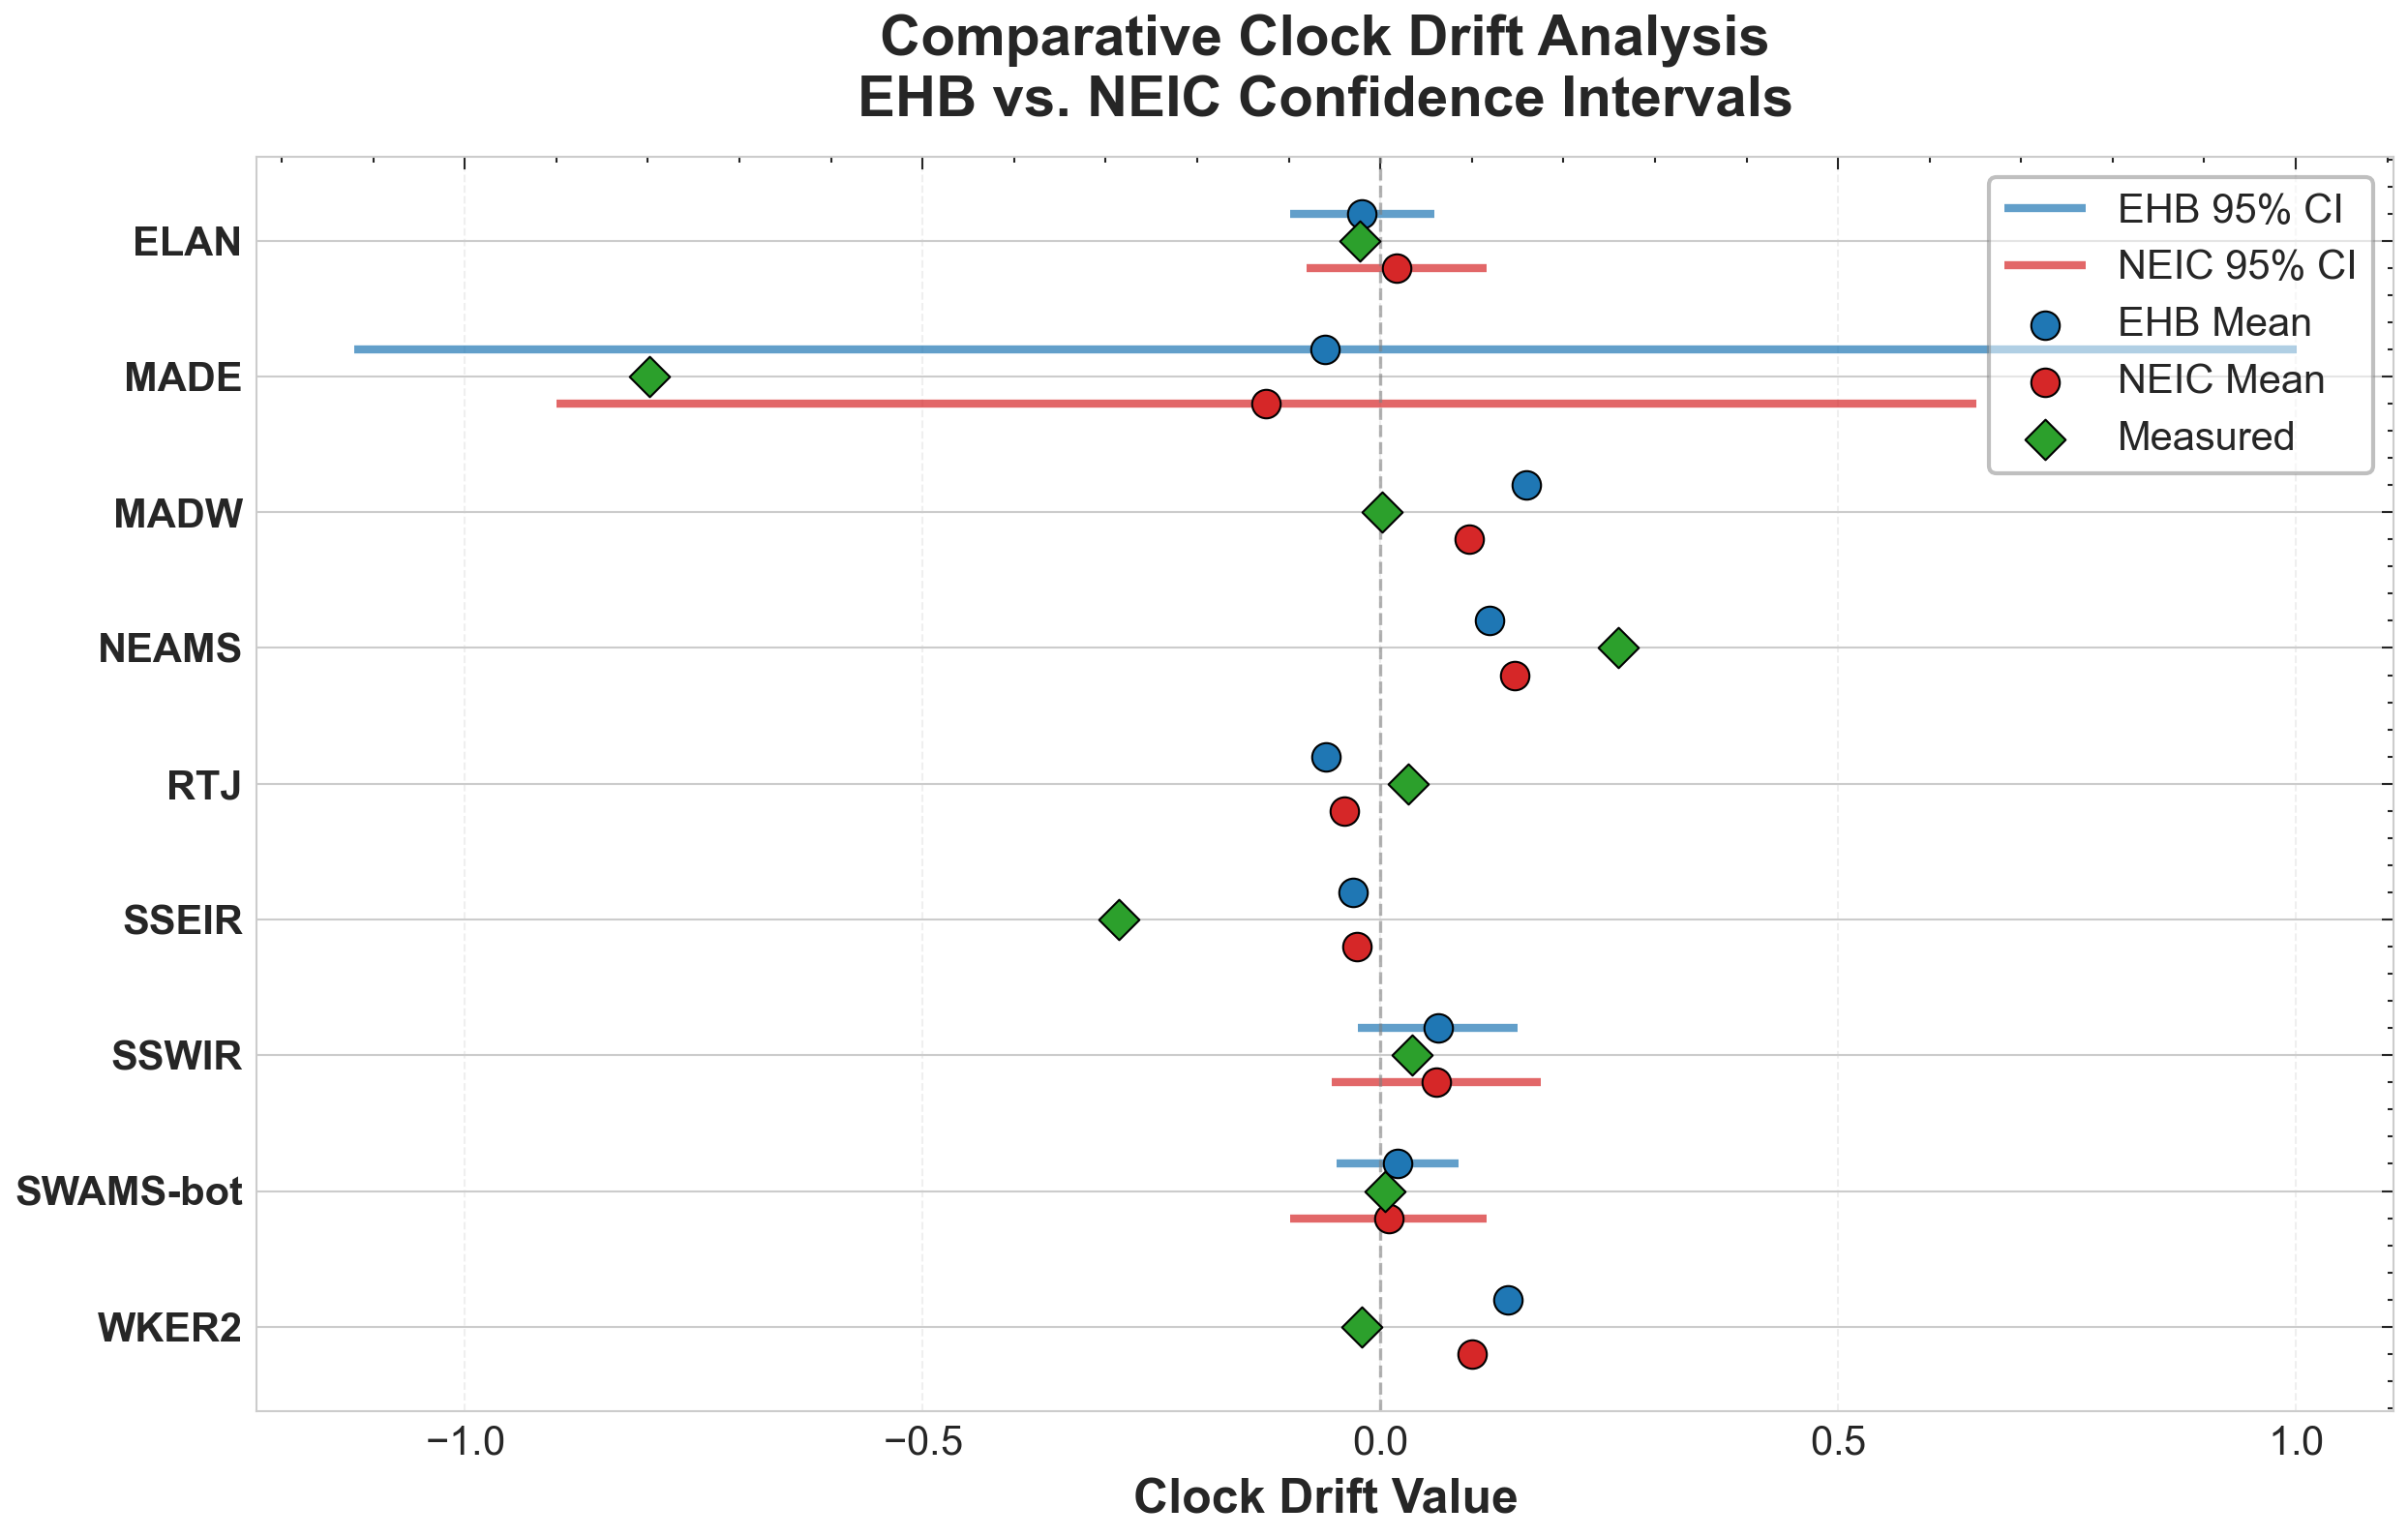

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import scienceplots
# Set up publication-quality figure
plt.style.use(['science','no-latex'])  # Requires `pip install scienceplots`
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'figure.dpi': 300,  # High resolution
})

# Categories (vertical axis labels)
categories = [
    "ELAN", "MADE", "MADW", "NEAMS",
    "RTJ", "SSEIR", "SSWIR", "SWAMS-bot", "WKER2"
]
N=[0,1,6,7]

# EHB values and bounds
ehb_means = [-0.020,-0.060,0.159,0.119,-0.059,-0.030,0.063,0.019,0.139]
ehb_lower = [-0.099,-1.121,0.086,0.058,-0.115,-0.085,-0.024,-0.048,-0.076]
ehb_upper = [0.059,1.001,0.221,0.179,-0.003,0.026,0.150,0.086,0.353]

# NEIC values and bounds
neic_means = [0.018,-0.125,0.097,0.147,-0.039,-0.026,0.061,0.009,0.1]
neic_lower = [-0.08,-0.9,0.017,0.072,-0.091,-0.104,-0.053,-0.098,-0.107]
neic_upper = [0.116,0.651,0.178,0.221,0.014,0.052,0.175,0.116,0.308]

# Measured clock-drift values
measured = [-0.0222,-0.7980,0.0020,0.2601,0.0300,-0.2861,0.0346,0.0048,-0.0203]

# Number of categories
n = len(categories)
y_positions = np.arange(n)

# Create figure with specific dimensions for publication
fig, ax = plt.subplots(figsize=(8.5, 5.5), dpi=300)

# Refined color palette
ehb_color = '#1F77B4'  # Professional blue
neic_color = '#D62728'  # Muted red
measured_color = '#2CA02C'  # Professional green

# Confidence interval width
ci_width = 2

# Plot EHB confidence intervals with precision
for i in N:
    ax.hlines(y_positions[i] - 0.2, ehb_lower[i], ehb_upper[i],
              color=ehb_color, linewidth=ci_width, alpha=0.7,
              label='EHB 95% CI' if i == 0 else "")

# Plot NEIC confidence intervals
for i in N:
    ax.hlines(y_positions[i] + 0.2, neic_lower[i], neic_upper[i],
              color=neic_color, linewidth=ci_width, alpha=0.7,
              label='NEIC 95% CI' if i == 0 else "")

# Scatter plot for means with enhanced aesthetics
ax.scatter(ehb_means, y_positions - 0.2,
           color=ehb_color, edgecolor='black',
           linewidth=0.5, s=50, zorder=3,
           label="EHB Mean")
ax.scatter(neic_means, y_positions + 0.2,
           color=neic_color, edgecolor='black',
           linewidth=0.5, s=50, zorder=3,
           label="NEIC Mean")

# Measured drift with distinctive marker
ax.scatter(measured, y_positions,
           color=measured_color, marker='D',
           edgecolor='black', linewidth=0.5,
           s=50, zorder=4, label="Measured")

# Refined axis formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(categories, fontweight='bold')
ax.invert_yaxis()  # First category on top

# Zero reference line with reduced prominence
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

# Labels and title with professional typography
ax.set_xlabel("Clock Drift Value", fontweight='bold')
ax.set_title("Comparative Clock Drift Analysis\nEHB vs. NEIC Confidence Intervals",
             fontweight='bold', pad=10)

# Enhanced legend
ax.legend(loc='best', frameon=True,
          edgecolor='gray', fancybox=True,
          framealpha=0.5)

# Tight layout with specific padding
plt.tight_layout(pad=1.1)

# Optional: Grid for better readability
ax.grid(axis='x', linestyle='--', alpha=0.3)

# Save with high quality (optional)
plt.savefig('clock_drift_comparison.png',
            dpi=300,
            bbox_inches='tight')

plt.show()

Demonstration of station selection:

2. Plot specific stations:

3. Available stations:
['ELAN', 'MADE', 'MADW', 'NEAMS', 'RTJ', 'SSEIR', 'SSWIR', 'SWAMS-bot', 'WKER2']


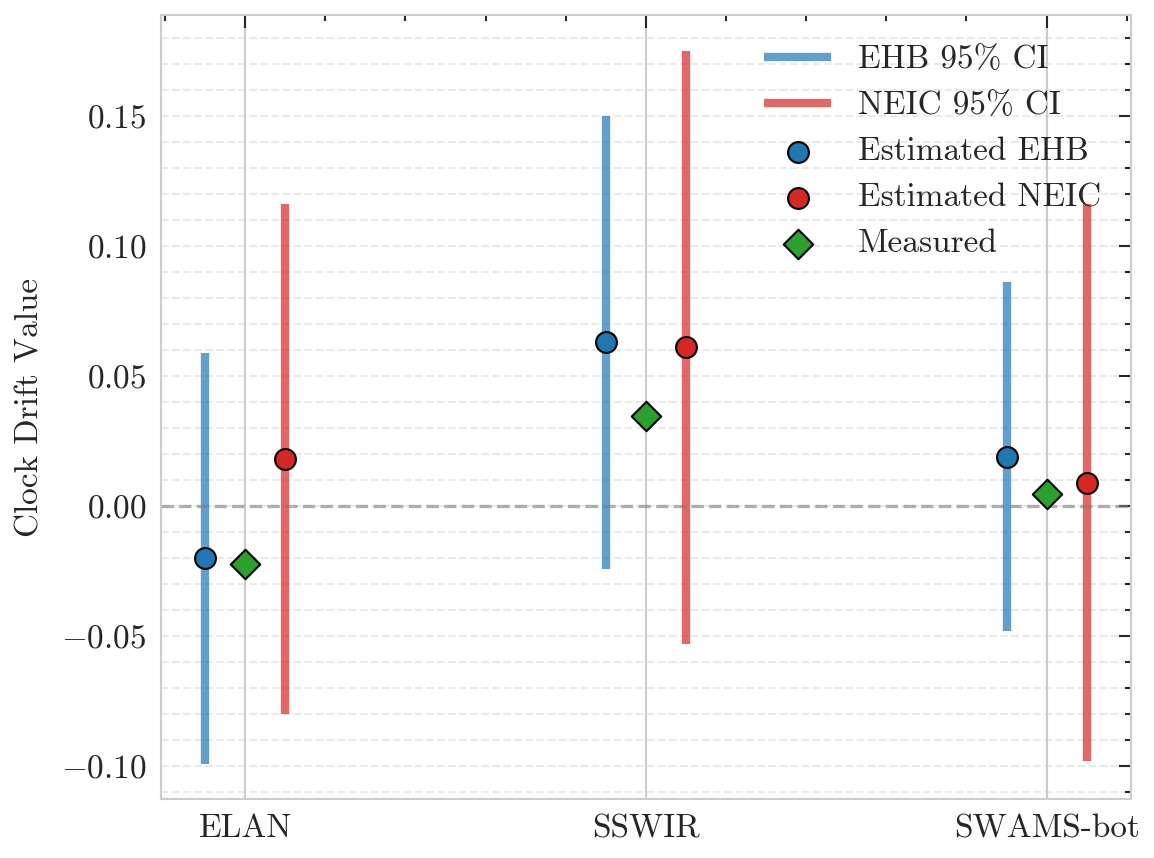

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_clock_drift(selected_stations=None):
    """
    Create a horizontal clock drift plot with optional station selection.

    Parameters:
    -----------
    selected_stations : list, optional
        List of station names to include in the plot.
        If None, all stations are plotted.
    """
    # Full dataset
    all_stations = [
        "ELAN", "MADE", "MADW", "NEAMS",
        "RTJ", "SSEIR", "SSWIR", "SWAMS-bot", "WKER2"
    ]

    # Full data arrays
    ehb_means = [-0.020, -0.060, 0.159, 0.119, -0.059, -0.030, 0.063, 0.019, 0.139]
    ehb_lower = [-0.099, -1.121, 0.086, 0.058, -0.115, -0.085, -0.024, -0.048, -0.076]
    ehb_upper = [ 0.059,  1.001, 0.221, 0.179, -0.003,  0.026,  0.150,  0.086,  0.353]

    neic_means = [0.018, -0.125, 0.097, 0.147, -0.039, -0.026, 0.061, 0.009, 0.100]
    neic_lower = [-0.08, -0.9,   0.017, 0.072, -0.091, -0.104, -0.053, -0.098, -0.107]
    neic_upper = [ 0.116, 0.651, 0.178, 0.221,  0.014,  0.052,  0.175,  0.116,  0.308]

    measured = [-0.0222, -0.7980, 0.0020, 0.2601, 0.0300, -0.2861, 0.0346, 0.0048, -0.0203]

    # If no stations selected, use all stations
    if selected_stations is None:
        selected_stations = all_stations

    # Filter the data based on selected stations
    filtered_indices = [all_stations.index(station) for station in selected_stations]

    # Extract filtered data
    filtered_stations = [all_stations[i] for i in filtered_indices]
    filtered_ehb_means = [ehb_means[i] for i in filtered_indices]
    filtered_ehb_lower = [ehb_lower[i] for i in filtered_indices]
    filtered_ehb_upper = [ehb_upper[i] for i in filtered_indices]

    filtered_neic_means = [neic_means[i] for i in filtered_indices]
    filtered_neic_lower = [neic_lower[i] for i in filtered_indices]
    filtered_neic_upper = [neic_upper[i] for i in filtered_indices]

    filtered_measured = [measured[i] for i in filtered_indices]

    # Plotting setup
    plt.style.use(['science','no-latex'])
    # plt.rcParams.update({
    #     'font.family': 'Arial',
    #     'font.size': 8,
    #     'axes.labelsize': 8,
    #     'axes.titlesize': 8,
    #     'figure.dpi': 300,
    # })

    # Create figure
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

    # Color palette
    # ehb_color = '#1F77B4'
    # neic_color = '#D62728'
    # measured_color = '#2CA02C'

    # Number of filtered categories
    n = len(filtered_stations)
    x_positions = np.arange(n)/2
    q =  0.05
    # Plot EHB confidence intervals horizontally
    for i in range(n):
        ax.vlines(x_positions[i] - q, filtered_ehb_lower[i], filtered_ehb_upper[i],
                  color=ehb_color, linewidth=2, alpha=0.7,
                  label='EHB 95% CI' if i == 0 else "")

    # Plot NEIC confidence intervals horizontally
    for i in range(n):
        ax.vlines(x_positions[i] + q, filtered_neic_lower[i], filtered_neic_upper[i],
                  color=neic_color, linewidth=2, alpha=0.7,
                  label='NEIC 95% CI' if i == 0 else "")

    # Scatter plot for means
    ax.scatter(x_positions - q, filtered_ehb_means,
               color=ehb_color, edgecolor='black',
               linewidth=0.5, s=25, zorder=3,
               label="Estimated EHB")
    ax.scatter(x_positions +q, filtered_neic_means,
               color=neic_color, edgecolor='black',
               linewidth=0.5, s=25, zorder=3,
               label="Estimated NEIC")

    # Measured drift
    ax.scatter(x_positions, filtered_measured,
               color=measured_color, marker='D',
               edgecolor='black', linewidth=0.5,
               s=25, zorder=4, label="Measured")

    # Axis formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(filtered_stations,ha='center')

    # Zero reference line
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

    # Labels and title
    ax.set_ylabel("Clock Drift Value")
    # ax.set_title("Comparative Clock Drift Analysis\nEHB vs. NEIC Confidence Intervals")

    # Enhanced legend
    ax.legend(fontsize=8) #loc='best', frameon=True,
              # edgecolor='gray', fancybox=True,
              # framealpha=0.5

    # Grid for readability
    ax.grid(axis='y', which = 'both', linestyle='--', alpha=0.4,)

    plt.tight_layout()
    # Save with high quality (optional)
    plt.savefig('clock_drift_comparison.png',
                dpi=300, bbox_inches='tight')


# Example usage demonstrations
def main():
    print("Demonstration of station selection:")

    # print("\n1. Plot all stations (default):")
    # plot_clock_drift()

    print("\n2. Plot specific stations:")
    # Example of selecting specific stations
    plot_clock_drift(["ELAN",  "SSWIR","SWAMS-bot"])

    print("\n3. Available stations:")
    print(["ELAN", "MADE", "MADW", "NEAMS", "RTJ", "SSEIR", "SSWIR", "SWAMS-bot", "WKER2"])

# Uncomment the following line to run demonstrations
main()